### Checks:
- Scales: Consitant Scales and Units: U, I, P, S, Q, _h, Angles
- Delete: Delete unnecessary measurements: total va total_arith vs total_vec
- Ranges: Set min, max values per machine and measurement and filter outliers
- Formulars: Make sure values make sense
    - Current [A] - I1, I2, I3, IN + harmonics: 1.) Rated Current Limits, 2.) I_sys = SUM(I)
    - Current fundamental [A] - I1_f, I2_f, I3_f, IN_f: 1.) Rated Current Limits, 2.) I_f_sys = SUM(I_f), 3.) I >= I_f
    - Current Harmonics [%] - THD, I1_h, I2_h, I3_h, IN_h: 1.) Acceptable limits (5-40%), 2.) THD <~ SUM(I_h)

    - Voltage [U] - U1, U2, U3, U12, U23 + harmonics: 1.) Rated Voltage Limits, 2.) U_avg = SUM(U)
    - Voltage fundamental[U] - U1_f, U2_f, U3_f, U12_f, U23_f: 1.) Rated Voltage Limits, 2.) U_avg_f = SUMU_f, 3.) U >= U_f
    - Voltage Harmonics [%] - THD, U1_h, U2_h, U3_h, U12_h, U23_h: 1.) Acceptable Limits (1-5%), 2.) THD <~ SUM(U_h) 

    - Power [P,S,Q] - P1, P2, P3, S1, S2, S3, Q1, Q2, Q3: 1.) Power limits, 2.) P=Sum(P), S=SUM(S), Q=SUM(Q)
    - Power fundamental [P,S,Q] - P1_f, P2_f, P3_f, S1_f, S2_f, S3_f, Q1_f, Q2_f, Q3_f: 1.) Power limits, 2.) P_tot_f = SUM(P_f) [also S, Q], 3.) P >= P_f [also S, Q]

    - Others: Freq (limits), Angles (limits), 
    - Unknown: LoadType?, Power Factor?, Rotation Field?

In [65]:
from pathlib import Path
import lzma, os

def fix_single_measurement_file(
    file_path=r"D:\EnergyDataset\dataset_clean\EPI_PumpStation2\PF_total\2024_PF_total_vec.csv.xz",
    old_meas_name="PF_total_vec",
    new_meas_name="PF_total",
    test=True,
):
    f = Path(file_path)
    if not f.exists() or not f.is_file():
        raise ValueError(f"File not found: {f}")

    # New filename in the same folder
    new_name = f.name.replace(f"_{old_meas_name}", f"_{new_meas_name}", 1)
    new_path = f.with_name(new_name)

    print(f"{'DRY-RUN' if test else 'EXECUTE'}: {f} -> {new_path}")

    # Stream header change (don’t load whole file)
    with lzma.open(f, mode="rt", encoding="utf-8", newline="") as fin:
        header = fin.readline()
        if not header:
            raise ValueError(f"Empty file or missing header: {f}")
        new_header = header.replace(old_meas_name, new_meas_name, 1)
        print(f"header:  {header.strip()}")
        print(f"header-> {new_header.strip()}")

        if test:
            return  # nothing written

        # Write temp with updated header, copy body verbatim
        tmp_out = f.with_name(new_name + ".tmp")
        with lzma.open(tmp_out, mode="wt", encoding="utf-8", newline="") as fout:
            fout.write(new_header)
            for line in fin:
                fout.write(line)

    # Atomically move temp to final name; then remove original if name changed
    os.replace(tmp_out, new_path)
    if new_path != f:
        f.unlink()

# ---- Example (dry run first) ----
fix_single_measurement_file(test=False)

# ---- Real execution ----
# fix_single_measurement_file(test=False)


EXECUTE: D:\EnergyDataset\dataset_clean\EPI_PumpStation2\PF_total\2024_PF_total_vec.csv.xz -> D:\EnergyDataset\dataset_clean\EPI_PumpStation2\PF_total\2024_PF_total.csv.xz
header:  WsDateTime,PF_total_vec
header-> WsDateTime,PF_total


In [68]:
from pathlib import Path
import lzma, os, math
from array import array

def build_single_validation_files(
    file_path_new=r"..\dataset_clean\EPI_PumpStation2\PF_total\2024_PF_total.csv.xz",
    validation_root_dir=r"..\dataset_clean_validation",
    step_seconds: int = 5,
    test: bool = True,
):
    """
    Create validation CSVs (missing + stats) for ONE renamed file.

    Inputs
    ------
    file_path_new : str|Path
        Full path to the new file, e.g.
        r"D:\EnergyDataset\dataset_clean\EPI_PumpStation2\PF_total\2024_PF_total.csv.xz"
        Assumes header is 'WsDateTime,<MEAS_NEW>'.
    validation_root_dir : str|Path
        Root folder for validation outputs, e.g. r"D:\EnergyDataset\dataset_clean_validation"
    step_seconds : int
        Sampling period in seconds (default 5).
    test : bool
        If True, do not write files; print target paths and CSV contents.

    Behavior
    --------
    - Streams the .xz file (no full load).
    - Computes missing-gap distribution, start/end/middle NaNs, zeros.
    - Computes min/max/mean/std and quantiles (exact).
    - Writes (or in test mode: prints) two CSVs:
        <validation_root>/<MACHINE>/<MEAS>/<YEAR_MEAS>_missing.csv
        <validation_root>/<MACHINE>/<MEAS>/<YEAR_MEAS>_stats.csv
    """
    f = Path(file_path_new)
    if not f.exists() or not f.is_file():
        raise ValueError(f"File not found: {f}")

    meas_dir = f.parent.name                  # e.g., PF_total
    machine  = f.parent.parent.name           # e.g., EPI_PumpStation2
    year_meas = f.name[:-7]                   # strip ".csv.xz" -> e.g., 2024_PF_total
    root_data = f.parents[3]                  # e.g., ...\dataset_clean

    out_dir = Path(validation_root_dir).resolve() / machine / meas_dir
    out_missing = out_dir / f"{year_meas}_missing.csv"
    out_stats   = out_dir / f"{year_meas}_stats.csv"

    # Rel path with forward slashes as requested
    file_rel = Path(root_data.name) / f.parent.relative_to(root_data) / f.name
    file_rel_str = file_rel.as_posix()

    # ---- helpers ----
    def percentile_from_sorted(sorted_vals, q: float) -> float:
        n = len(sorted_vals)
        if n == 0:
            return float('nan')
        if n == 1:
            return sorted_vals[0]
        pos = (q / 100.0) * (n - 1)
        lo = int(math.floor(pos)); hi = int(math.ceil(pos))
        if lo == hi: return sorted_vals[lo]
        frac = pos - lo
        return sorted_vals[lo] * (1.0 - frac) + sorted_vals[hi] * frac

    ONE_STEP = 1
    steps_30s = int(30 // step_seconds)
    steps_1m  = int(60 // step_seconds)
    steps_15m = int(15 * 60 // step_seconds)
    steps_1h  = int(60 * 60 // step_seconds)
    steps_24h = int(24 * 60 * 60 // step_seconds)
    steps_7d  = int(7 * 24 * 60 * 60 // step_seconds)
    steps_1mo = int(30 * 24 * 60 * 60 // step_seconds)

    def gap_bucket(L):
        if L == ONE_STEP: return "nan_1_step"
        if 2 <= L <= steps_30s: return "nan_5s_30s"
        if steps_30s < L <= steps_1m: return "nan_30s_1m"
        if steps_1m < L <= steps_15m: return "nan_1m_15m"
        if steps_15m < L <= steps_1h: return "nan_15m_1h"
        if steps_1h < L <= steps_24h: return "nan_1h_24h"
        if steps_24h < L <= steps_7d: return "nan_1d_7d"
        if steps_7d < L <= steps_1mo: return "nan_1w_1mo"
        return "nan_1mo_inf"

    missing_header = ",".join([
        "file_path","n_total","n_nans","n_zeros","n_nans_start","n_nans_end","n_nans_middle",
        "n_missing_gaps","missing_gap_total_sec",
        "nan_1_step_count","nan_1_step_steps","nan_1_step_pct",
        "nan_5s_30s_count","nan_5s_30s_steps","nan_5s_30s_pct",
        "nan_30s_1m_count","nan_30s_1m_steps","nan_30s_1m_pct",
        "nan_1m_15m_count","nan_1m_15m_steps","nan_1m_15m_pct",
        "nan_15m_1h_count","nan_15m_1h_steps","nan_15m_1h_pct",
        "nan_1h_24h_count","nan_1h_24h_steps","nan_1h_24h_pct",
        "nan_1d_7d_count","nan_1d_7d_steps","nan_1d_7d_pct",
        "nan_1w_1mo_count","nan_1w_1mo_steps","nan_1w_1mo_pct",
        "nan_1mo_inf_count","nan_1mo_inf_steps","nan_1mo_inf_pct",
    ])
    stats_header = ",".join([
        "file_path","min","max","mean","std","q01","q05","q25","q50","q75","q95","q99"
    ])

    # ---- streaming pass ----
    n_total = 0; n_nans = 0; n_zeros = 0
    nan_run_lengths = []; in_nan_run = False; cur_run_len = 0
    n_valid = 0; mean = 0.0; M2 = 0.0
    vmin = None; vmax = None; vals = array('d')

    with lzma.open(f, mode="rt", encoding="utf-8", newline="") as fin:
        header = fin.readline()
        if not header:
            raise ValueError(f"Empty file or missing header: {f}")
        cols = header.strip().split(",")
        if len(cols) != 2 or cols[0] != "WsDateTime":
            raise ValueError(f"Unexpected header in {f}: '{header.strip()}'")
        # second column name not strictly needed here; we just parse numbers

        for line in fin:
            if not line: continue
            parts = line.rstrip("\n").split(",", 1)
            if len(parts) != 2: continue
            n_total += 1
            try:
                val = float(parts[1])
            except ValueError:
                val = float('nan')

            if math.isnan(val):
                n_nans += 1
                if in_nan_run: cur_run_len += 1
                else:
                    in_nan_run = True
                    cur_run_len = 1
                continue

            if in_nan_run:
                nan_run_lengths.append(cur_run_len)
                in_nan_run = False
                cur_run_len = 0

            if val == 0.0: n_zeros += 1

            n_valid += 1
            d = val - mean
            mean += d / n_valid
            M2 += d * (val - mean)
            vmin = val if vmin is None else min(vmin, val)
            vmax = val if vmax is None else max(vmax, val)
            vals.append(val)

        if in_nan_run:
            nan_run_lengths.append(cur_run_len)

    # start/end/middle NaNs
    n_nans_start = 0; n_nans_end = 0; n_nans_middle = n_nans
    if nan_run_lengths:
        # first row
        with lzma.open(f, mode="rt", encoding="utf-8", newline="") as fin:
            _ = fin.readline()
            first_line = fin.readline()
            first_nan = False
            if first_line:
                p = first_line.rstrip("\n").split(",", 1)
                try:
                    first_nan = (len(p) == 2 and math.isnan(float(p[1])))
                except ValueError:
                    first_nan = True
        # last row
        last_nan = False
        with lzma.open(f, mode="rt", encoding="utf-8", newline="") as fin:
            _ = fin.readline()
            last_val = None
            for line in fin:
                if not line or line == "\n": continue
                p = line.rstrip("\n").split(",", 1)
                if len(p) == 2: last_val = p[1]
            if last_val is not None:
                try:
                    last_nan = math.isnan(float(last_val))
                except ValueError:
                    last_nan = True
        if first_nan: n_nans_start = nan_run_lengths[0]
        if last_nan:  n_nans_end   = nan_run_lengths[-1]
        n_nans_middle = n_nans - n_nans_start - n_nans_end

    n_missing_gaps = len(nan_run_lengths)
    missing_gap_total_steps = sum(nan_run_lengths)
    missing_gap_total_sec = missing_gap_total_steps * step_seconds

    bucket_names = [
        "nan_1_step","nan_5s_30s","nan_30s_1m","nan_1m_15m",
        "nan_15m_1h","nan_1h_24h","nan_1d_7d","nan_1w_1mo","nan_1mo_inf"
    ]
    bucket_counts = {k: 0 for k in bucket_names}
    bucket_steps  = {k: 0 for k in bucket_names}
    for L in nan_run_lengths:
        b = gap_bucket(L)
        bucket_counts[b] += 1
        bucket_steps[b]  += L

    def pct(steps): return (steps * 100.0 / n_nans) if n_nans > 0 else 0.0

    std = math.sqrt(M2 / n_valid) if n_valid > 1 else float('nan')
    vals_sorted = sorted(vals)
    q01 = percentile_from_sorted(vals_sorted, 1.0)
    q05 = percentile_from_sorted(vals_sorted, 5.0)
    q25 = percentile_from_sorted(vals_sorted, 25.0)
    q50 = percentile_from_sorted(vals_sorted, 50.0)
    q75 = percentile_from_sorted(vals_sorted, 75.0)
    q95 = percentile_from_sorted(vals_sorted, 95.0)
    q99 = percentile_from_sorted(vals_sorted, 99.0)

    missing_row = ",".join(map(str, [
        file_rel_str, n_total, n_nans, n_zeros, n_nans_start, n_nans_end, n_nans_middle,
        n_missing_gaps, missing_gap_total_sec,
        bucket_counts["nan_1_step"], bucket_steps["nan_1_step"], round(pct(bucket_steps["nan_1_step"]), 2),
        bucket_counts["nan_5s_30s"], bucket_steps["nan_5s_30s"], round(pct(bucket_steps["nan_5s_30s"]), 2),
        bucket_counts["nan_30s_1m"], bucket_steps["nan_30s_1m"], round(pct(bucket_steps["nan_30s_1m"]), 2),
        bucket_counts["nan_1m_15m"], bucket_steps["nan_1m_15m"], round(pct(bucket_steps["nan_1m_15m"]), 2),
        bucket_counts["nan_15m_1h"], bucket_steps["nan_15m_1h"], round(pct(bucket_steps["nan_15m_1h"]), 2),
        bucket_counts["nan_1h_24h"], bucket_steps["nan_1h_24h"], round(pct(bucket_steps["nan_1h_24h"]), 2),
        bucket_counts["nan_1d_7d"], bucket_steps["nan_1d_7d"], round(pct(bucket_steps["nan_1d_7d"]), 2),
        bucket_counts["nan_1w_1mo"], bucket_steps["nan_1w_1mo"], round(pct(bucket_steps["nan_1w_1mo"]), 2),
        bucket_counts["nan_1mo_inf"], bucket_steps["nan_1mo_inf"], round(pct(bucket_steps["nan_1mo_inf"]), 2),
    ]))
    stats_row = ",".join(map(str, [
        file_rel_str,
        vmin if vmin is not None else float('nan'),
        vmax if vmax is not None else float('nan'),
        mean if n_valid > 0 else float('nan'),
        std, q01, q05, q25, q50, q75, q95, q99
    ]))

    if test:
        print(f"[TEST] Would save to:")
        print(f"  {out_missing}")
        print(f"  {out_stats}")
        print("[TEST] --- MISSING CSV CONTENT ---")
        print(missing_header)
        print(missing_row)
        print("[TEST] --- STATS CSV CONTENT ---")
        print(stats_header)
        print(stats_row)
        return

    # real write
    out_dir.mkdir(parents=True, exist_ok=True)
    tmp_missing = out_missing.with_suffix(out_missing.suffix + ".tmp")
    tmp_stats   = out_stats.with_suffix(out_stats.suffix + ".tmp")
    with open(tmp_missing, "w", encoding="utf-8", newline="") as fo:
        fo.write(missing_header + "\n"); fo.write(missing_row + "\n")
    with open(tmp_stats, "w", encoding="utf-8", newline="") as fo:
        fo.write(stats_header + "\n"); fo.write(stats_row + "\n")
    os.replace(tmp_missing, out_missing)
    os.replace(tmp_stats, out_stats)
    print(f"OK -> {out_missing}")
    print(f"OK -> {out_stats}")

# ---- Example usage ----
# DRY RUN:
build_single_validation_files(test=False)

# REAL:
# build_single_validation_files(test=False)


OK -> D:\EnergyDataset\dataset_clean_validation\EPI_PumpStation2\PF_total\2024_PF_total_missing.csv
OK -> D:\EnergyDataset\dataset_clean_validation\EPI_PumpStation2\PF_total\2024_PF_total_stats.csv


In [71]:
from pathlib import Path
import lzma, os, math
from array import array

THD_FIX_MEASUREMENTS = {
    'THD_U1','THD_U12','THD_U2','THD_U23','THD_U3','THD_U31','THD_I1','THD_I2','THD_I3','THD_IN'
}

def rebuild_thd_validation_from_validation_index(
    validation_root_dir=r"D:\EnergyDataset\dataset_clean_validation",
    data_root_dir=r"D:\EnergyDataset\dataset_clean",
    step_seconds: int = 5,
    test: bool = True,
):
    """
    Rebuild validation CSVs for THD measurements by ONLY traversing dataset_clean_validation.
    For each <validation_root>/<MACHINE>/<MEAS> where MEAS in THD_FIX_MEASUREMENTS:
      - Determine target files from existing *_missing.csv / *_stats.csv stems (YEAR_MEAS).
      - Delete old validation files.
      - Recompute by reading the corresponding data file:
            <data_root>/<MACHINE>/<MEAS>/<YEAR_MEAS>.csv.xz
      - Write new *_missing.csv and *_stats.csv (or print contents in test mode).

    Notes:
      - 'file_path' in outputs is always 'dataset_clean/...'(forward slashes).
      - Prints the dataset_clean data file path for visibility.
      - Hard-fail (no try/except).
    """
    val_root = Path(validation_root_dir).resolve()
    data_root = Path(data_root_dir).resolve()

    if not val_root.exists() or not val_root.is_dir():
        raise ValueError(f"Validation root not found or not a directory: {val_root}")
    if not data_root.exists() or not data_root.is_dir():
        raise ValueError(f"Data root not found or not a directory: {data_root}")

    def percentile_from_sorted(sorted_vals, q: float) -> float:
        n = len(sorted_vals)
        if n == 0: return float('nan')
        if n == 1: return sorted_vals[0]
        pos = (q / 100.0) * (n - 1)
        lo = int(math.floor(pos)); hi = int(math.ceil(pos))
        if lo == hi: return sorted_vals[lo]
        frac = pos - lo
        return sorted_vals[lo] * (1.0 - frac) + sorted_vals[hi] * frac

    ONE_STEP = 1
    steps_30s = int(30 // step_seconds)
    steps_1m  = int(60 // step_seconds)
    steps_15m = int(15 * 60 // step_seconds)
    steps_1h  = int(60 * 60 // step_seconds)
    steps_24h = int(24 * 60 * 60 // step_seconds)
    steps_7d  = int(7 * 24 * 60 * 60 // step_seconds)
    steps_1mo = int(30 * 24 * 60 * 60 // step_seconds)

    def gap_bucket(L):
        if L == ONE_STEP: return "nan_1_step"
        if 2 <= L <= steps_30s: return "nan_5s_30s"
        if steps_30s < L <= steps_1m: return "nan_30s_1m"
        if steps_1m < L <= steps_15m: return "nan_1m_15m"
        if steps_15m < L <= steps_1h: return "nan_15m_1h"
        if steps_1h < L <= steps_24h: return "nan_1h_24h"
        if steps_24h < L <= steps_7d: return "nan_1d_7d"
        if steps_7d < L <= steps_1mo: return "nan_1w_1mo"
        return "nan_1mo_inf"

    missing_header = ",".join([
        "file_path","n_total","n_nans","n_zeros","n_nans_start","n_nans_end","n_nans_middle",
        "n_missing_gaps","missing_gap_total_sec",
        "nan_1_step_count","nan_1_step_steps","nan_1_step_pct",
        "nan_5s_30s_count","nan_5s_30s_steps","nan_5s_30s_pct",
        "nan_30s_1m_count","nan_30s_1m_steps","nan_30s_1m_pct",
        "nan_1m_15m_count","nan_1m_15m_steps","nan_1m_15m_pct",
        "nan_15m_1h_count","nan_15m_1h_steps","nan_15m_1h_pct",
        "nan_1h_24h_count","nan_1h_24h_steps","nan_1h_24h_pct",
        "nan_1d_7d_count","nan_1d_7d_steps","nan_1d_7d_pct",
        "nan_1w_1mo_count","nan_1w_1mo_steps","nan_1w_1mo_pct",
        "nan_1mo_inf_count","nan_1mo_inf_steps","nan_1mo_inf_pct",
    ])
    stats_header = ",".join([
        "file_path","min","max","mean","std","q01","q05","q25","q50","q75","q95","q99"
    ])

    print(f"{'DRY-RUN' if test else 'EXECUTE'}: Rebuilding THD validation by scanning {val_root}")
    print("-" * 100)

    # Traverse only validation tree
    for machine_dir in sorted([p for p in val_root.iterdir() if p.is_dir()]):
        machine = machine_dir.name
        for meas_dir in sorted([p for p in machine_dir.iterdir() if p.is_dir() and p.name in THD_FIX_MEASUREMENTS]):
            meas = meas_dir.name

            # Determine target stems (YEAR_MEAS) from existing validation files
            stems = set()
            for f in meas_dir.glob("*_missing.csv"):
                stems.add(f.name.replace("_missing.csv",""))
            for f in meas_dir.glob("*_stats.csv"):
                stems.add(f.name.replace("_stats.csv",""))
            if not stems:
                # Nothing to rebuild for this measurement here
                continue

            for stem in sorted(stems):
                # Build validation file paths
                out_missing = meas_dir / f"{stem}_missing.csv"
                out_stats   = meas_dir / f"{stem}_stats.csv"

                # Map to data file in dataset_clean WITHOUT scanning dataset_clean
                data_file = data_root / machine / meas / f"{stem}.csv.xz"
                # For printing + CSV field: always starting with dataset_clean/ and forward slashes
                file_rel_str = (Path("dataset_clean") / machine / meas / f"{stem}.csv.xz").as_posix()

                print(f"\nTarget: {machine}/{meas}/{stem}")
                print(f"Data  : {data_file}")

                # Delete existing validation files (or show intent in test)
                if test:
                    if out_missing.exists():
                        print(f"[TEST] would DELETE -> {out_missing}")
                    else:
                        print(f"[TEST] (no existing) {out_missing}")
                    if out_stats.exists():
                        print(f"[TEST] would DELETE -> {out_stats}")
                    else:
                        print(f"[TEST] (no existing) {out_stats}")
                else:
                    if out_missing.exists(): out_missing.unlink()
                    if out_stats.exists():   out_stats.unlink()

                # Compute validation by streaming the data file
                # (hard-fail if file missing or malformed)
                n_total = 0; n_nans = 0; n_zeros = 0
                nan_run_lengths = []; in_nan_run = False; cur_run_len = 0
                n_valid = 0; mean = 0.0; M2 = 0.0
                vmin = None; vmax = None; vals = array('d')

                with lzma.open(data_file, mode="rt", encoding="utf-8", newline="") as fin:
                    header = fin.readline()
                    if not header:
                        raise ValueError(f"Empty file or missing header: {data_file}")
                    cols = header.strip().split(",")
                    if len(cols) != 2 or cols[0] != "WsDateTime" or cols[1] != meas:
                        raise ValueError(f"Unexpected header in {data_file}: '{header.strip()}'")

                    for line in fin:
                        if not line: continue
                        parts = line.rstrip("\n").split(",", 1)
                        if len(parts) != 2: continue
                        n_total += 1
                        try:
                            val = float(parts[1])
                        except ValueError:
                            val = float('nan')

                        if math.isnan(val):
                            n_nans += 1
                            if in_nan_run: cur_run_len += 1
                            else:
                                in_nan_run = True
                                cur_run_len = 1
                            continue

                        if in_nan_run:
                            nan_run_lengths.append(cur_run_len)
                            in_nan_run = False
                            cur_run_len = 0

                        if val == 0.0: n_zeros += 1

                        n_valid += 1
                        d = val - mean
                        mean += d / n_valid
                        M2 += d * (val - mean)
                        vmin = val if vmin is None else min(vmin, val)
                        vmax = val if vmax is None else max(vmax, val)
                        vals.append(val)

                    if in_nan_run:
                        nan_run_lengths.append(cur_run_len)

                # start/end/middle NaNs
                n_nans_start = 0; n_nans_end = 0; n_nans_middle = n_nans
                if nan_run_lengths:
                    with lzma.open(data_file, mode="rt", encoding="utf-8", newline="") as fin:
                        _ = fin.readline()
                        first_line = fin.readline()
                        first_nan = False
                        if first_line:
                            p = first_line.rstrip("\n").split(",", 1)
                            try:
                                first_nan = (len(p) == 2 and math.isnan(float(p[1])))
                            except ValueError:
                                first_nan = True
                    last_nan = False
                    with lzma.open(data_file, mode="rt", encoding="utf-8", newline="") as fin:
                        _ = fin.readline()
                        last_val = None
                        for line in fin:
                            if not line or line == "\n": continue
                            p = line.rstrip("\n").split(",", 1)
                            if len(p) == 2: last_val = p[1]
                        if last_val is not None:
                            try:
                                last_nan = math.isnan(float(last_val))
                            except ValueError:
                                last_nan = True
                    if first_nan: n_nans_start = nan_run_lengths[0]
                    if last_nan:  n_nans_end   = nan_run_lengths[-1]
                    n_nans_middle = n_nans - n_nans_start - n_nans_end

                n_missing_gaps = len(nan_run_lengths)
                missing_gap_total_steps = sum(nan_run_lengths)
                missing_gap_total_sec = missing_gap_total_steps * step_seconds

                bucket_names = [
                    "nan_1_step","nan_5s_30s","nan_30s_1m","nan_1m_15m",
                    "nan_15m_1h","nan_1h_24h","nan_1d_7d","nan_1w_1mo","nan_1mo_inf"
                ]
                bucket_counts = {k: 0 for k in bucket_names}
                bucket_steps  = {k: 0 for k in bucket_names}
                for L in nan_run_lengths:
                    b = gap_bucket(L)
                    bucket_counts[b] += 1
                    bucket_steps[b]  += L

                def pct(steps): return (steps * 100.0 / n_nans) if n_nans > 0 else 0.0

                std = math.sqrt(M2 / n_valid) if n_valid > 1 else float('nan')
                vals_sorted = sorted(vals)
                q01 = percentile_from_sorted(vals_sorted, 1.0)
                q05 = percentile_from_sorted(vals_sorted, 5.0)
                q25 = percentile_from_sorted(vals_sorted, 25.0)
                q50 = percentile_from_sorted(vals_sorted, 50.0)
                q75 = percentile_from_sorted(vals_sorted, 75.0)
                q95 = percentile_from_sorted(vals_sorted, 95.0)
                q99 = percentile_from_sorted(vals_sorted, 99.0)

                missing_row = ",".join(map(str, [
                    file_rel_str, n_total, n_nans, n_zeros, n_nans_start, n_nans_end, n_nans_middle,
                    n_missing_gaps, missing_gap_total_sec,
                    bucket_counts["nan_1_step"], bucket_steps["nan_1_step"], round(pct(bucket_steps["nan_1_step"]), 2),
                    bucket_counts["nan_5s_30s"], bucket_steps["nan_5s_30s"], round(pct(bucket_steps["nan_5s_30s"]), 2),
                    bucket_counts["nan_30s_1m"], bucket_steps["nan_30s_1m"], round(pct(bucket_steps["nan_30s_1m"]), 2),
                    bucket_counts["nan_1m_15m"], bucket_steps["nan_1m_15m"], round(pct(bucket_steps["nan_1m_15m"]), 2),
                    bucket_counts["nan_15m_1h"], bucket_steps["nan_15m_1h"], round(pct(bucket_steps["nan_15m_1h"]), 2),
                    bucket_counts["nan_1h_24h"], bucket_steps["nan_1h_24h"], round(pct(bucket_steps["nan_1h_24h"]), 2),
                    bucket_counts["nan_1d_7d"], bucket_steps["nan_1d_7d"], round(pct(bucket_steps["nan_1d_7d"]), 2),
                    bucket_counts["nan_1w_1mo"], bucket_steps["nan_1w_1mo"], round(pct(bucket_steps["nan_1w_1mo"]), 2),
                    bucket_counts["nan_1mo_inf"], bucket_steps["nan_1mo_inf"], round(pct(bucket_steps["nan_1mo_inf"]), 2),
                ]))
                stats_row = ",".join(map(str, [
                    file_rel_str,
                    vmin if (vmin:= (None if len(vals)==0 else min(vals))) is not None else float('nan'),
                    vmax if (vmax:= (None if len(vals)==0 else max(vals))) is not None else float('nan'),
                    (mean if n_valid > 0 else float('nan')),
                    std, q01, q05, q25, q50, q75, q95, q99
                ]))

                if test:
                    print("[TEST] --- MISSING CSV CONTENT ---")
                    print(missing_header)
                    print(missing_row)
                    print("[TEST] --- STATS CSV CONTENT ---")
                    print(stats_header)
                    print(stats_row)
                else:
                    # Write atomically
                    tmp_missing = out_missing.with_suffix(out_missing.suffix + ".tmp")
                    tmp_stats   = out_stats.with_suffix(out_stats.suffix + ".tmp")
                    with open(tmp_missing, "w", encoding="utf-8", newline="") as fo:
                        fo.write(missing_header + "\n"); fo.write(missing_row + "\n")
                    with open(tmp_stats, "w", encoding="utf-8", newline="") as fo:
                        fo.write(stats_header + "\n"); fo.write(stats_row + "\n")
                    os.replace(tmp_missing, out_missing)
                    os.replace(tmp_stats, out_stats)
                    print(f"OK -> {out_missing}")
                    print(f"OK -> {out_stats}")

    print("\n" + "-" * 100)
    print("Done.")

# --- Example ---
# TEST (prints dataset_clean path + CSV contents, no writes):
rebuild_thd_validation_from_validation_index(test=False)


EXECUTE: Rebuilding THD validation by scanning D:\EnergyDataset\dataset_clean_validation
----------------------------------------------------------------------------------------------------

Target: EPI_ChipPress/THD_I1/2018_THD_I1
Data  : D:\EnergyDataset\dataset_clean\EPI_ChipPress\THD_I1\2018_THD_I1.csv.xz
OK -> D:\EnergyDataset\dataset_clean_validation\EPI_ChipPress\THD_I1\2018_THD_I1_missing.csv
OK -> D:\EnergyDataset\dataset_clean_validation\EPI_ChipPress\THD_I1\2018_THD_I1_stats.csv

Target: EPI_ChipPress/THD_I1/2019_THD_I1
Data  : D:\EnergyDataset\dataset_clean\EPI_ChipPress\THD_I1\2019_THD_I1.csv.xz
OK -> D:\EnergyDataset\dataset_clean_validation\EPI_ChipPress\THD_I1\2019_THD_I1_missing.csv
OK -> D:\EnergyDataset\dataset_clean_validation\EPI_ChipPress\THD_I1\2019_THD_I1_stats.csv

Target: EPI_ChipPress/THD_I1/2020_THD_I1
Data  : D:\EnergyDataset\dataset_clean\EPI_ChipPress\THD_I1\2020_THD_I1.csv.xz
OK -> D:\EnergyDataset\dataset_clean_validation\EPI_ChipPress\THD_I1\2020_THD_I

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\EnergyDataset\\dataset_clean\\EPI_ChipSaw\\THD_IN\\2019_THD_IN.csv.xz'

### Delete

In [ ]:
import os
import shutil

def _unique_dest_dir(dest_dir: str) -> str:
    """
    If dest_dir exists, return a variant with _bakN appended to the last path segment.
    """
    if not os.path.exists(dest_dir):
        return dest_dir
    parent = os.path.dirname(dest_dir)
    base = os.path.basename(dest_dir)
    k = 1
    while True:
        cand = os.path.join(parent, f"{base}_bak{k}")
        if not os.path.exists(cand):
            return cand
        k += 1

def _move_dir(src_dir: str, backup_root: str, dry_run: bool) -> bool:
    """
    Move the entire src_dir into backup_root while mirroring the relative structure
    starting from the machine directory (i.e., <machine>/<measurement>).
    Returns True if moved (or would move in dry-run), False if skipped.
    """
    if not os.path.isdir(src_dir):
        return False

    # Build <backup_root>/<machine>/<measurement> destination
    # src_dir looks like: <root>/<machine>/<measurement>
    machine = os.path.basename(os.path.dirname(src_dir))
    measurement = os.path.basename(src_dir)
    dest_parent = os.path.join(backup_root, machine)
    os.makedirs(dest_parent, exist_ok=True)
    dest_dir = os.path.join(dest_parent, measurement)

    # Ensure uniqueness
    dest_dir = _unique_dest_dir(dest_dir)

    if dry_run:
        print(f"[DRY] MOVE DIR  {src_dir}  ->  {dest_dir}")
        return True

    try:
        shutil.move(src_dir, dest_dir)
        print(f"[OK]  MOVED DIR {src_dir}  ->  {dest_dir}")
        return True
    except Exception as e:
        print(f"[FAIL] MOVE DIR {src_dir}  (error: {e})")
        return False

def move_measurement_folders_for_epi_and_tec(
    measurements,
    root_clean: str = "../dataset_clean",
    root_stats: str = "../dataset_clean_validation",
    backup_clean_root: str = "./backup_clean_dirs",
    backup_stats_root: str = "./backup_validation_dirs",
    dry_run: bool = True,
):
    """
    For each measurement in `measurements`, move the ENTIRE measurement folder
    from both data and validation trees to backup roots, for all machines whose
    names contain 'EPI' or 'TEC' (case-insensitive) and do NOT contain 'PV'.

    Example:
      Move:
        ../dataset_clean/TEC_48S/IN_fund/         -> ./backup_clean_dirs/TEC_48S/IN_fund[_bakN]
        ../dataset_clean_validation/TEC_48S/IN_fund/ -> ./backup_validation_dirs/TEC_48S/IN_fund[_bakN]

    Notes:
      - Folders are moved (not deleted), preserving all files like:
          2024_<measurement>.csv.xz, 2024_<measurement>_missing.csv, 2024_<measurement>_stats.csv, etc.
      - Never overwrites: if destination exists, a suffix _bakN is appended to the *folder name*.
      - `dry_run=True` prints planned moves only.
    """
    if not os.path.isdir(root_clean):
        print(f"[ERROR] Data root not found: {root_clean}")
        return
    if not os.path.isdir(root_stats):
        print(f"[ERROR] Validation root not found: {root_stats}")
        return

    os.makedirs(backup_clean_root, exist_ok=True)
    os.makedirs(backup_stats_root, exist_ok=True)

    # Discover eligible machines (EPI or TEC, not PV)
    machines = sorted(
        d for d in os.listdir(root_clean)
        if os.path.isdir(os.path.join(root_clean, d))
        and ("pv" not in d.lower())
        and (("epi" in d.lower()) or ("tec" in d.lower()))
    )

    if not machines:
        print("[INFO] No EPI/TEC machines found (excluding PV).")
        return

    processed_clean = 0
    processed_stats = 0
    skipped_clean = 0
    skipped_stats = 0

    for m in machines:
        for meas in measurements:
            src_clean_dir = os.path.join(root_clean, m, meas)
            src_stats_dir = os.path.join(root_stats, m, meas)

            # Move DATA directory
            if os.path.isdir(src_clean_dir):
                if _move_dir(src_clean_dir, backup_clean_root, dry_run):
                    processed_clean += 1
            else:
                skipped_clean += 1

            # Move VALIDATION directory
            if os.path.isdir(src_stats_dir):
                if _move_dir(src_stats_dir, backup_stats_root, dry_run):
                    processed_stats += 1
            else:
                skipped_stats += 1

    print(
        f"\nSummary (folders): "
        f"data moved={processed_clean}, data missing/skip={skipped_clean}, "
        f"validation moved={processed_stats}, validation missing/skip={skipped_stats}"
    )


# --- Example usage (uncomment to run) ---
to_remove = ["I1_DC", "I2_DC", "I3_DC", "IN_DC",
             "U1_DC", "U2_DC", "U3_DC", "U12_DC", "U23_DC", "U31_DC",
             "I1_RMS_fund", "I2_RMS_fund", "I3_RMS_fund", "IN_RMS_fund",
             "U1_RMS_fund", "U2_RMS_fund", "U3_RMS_fund", "U12_RMS_fund", "U23_RMS_fund", "U31_RMS_fund",
             "I1_fund", "I2_fund", "I3_fund", "IN_fund",
             "U1_fund", "U2_fund", "U3_fund", "U12_fund", "U23_fund", "U31_fund",
             ]
# Preview what would be moved:
# move_measurement_folders_for_epi_and_tec(to_remove,root_clean="../dataset_clean",root_stats="../dataset_clean_validation",
#                                         backup_clean_root="./backup_clean_dirs", backup_stats_root="./backup_validation_dirs",dry_run=True,)


[OK]  MOVED DIR ../dataset_clean\TEC_48S\I1_RMS_fund  ->  ./backup_clean_dirs\TEC_48S\I1_RMS_fund
[OK]  MOVED DIR ../dataset_clean_validation\TEC_48S\I1_RMS_fund  ->  ./backup_validation_dirs\TEC_48S\I1_RMS_fund
[OK]  MOVED DIR ../dataset_clean\TEC_48S\I2_RMS_fund  ->  ./backup_clean_dirs\TEC_48S\I2_RMS_fund
[OK]  MOVED DIR ../dataset_clean_validation\TEC_48S\I2_RMS_fund  ->  ./backup_validation_dirs\TEC_48S\I2_RMS_fund
[OK]  MOVED DIR ../dataset_clean\TEC_48S\I3_RMS_fund  ->  ./backup_clean_dirs\TEC_48S\I3_RMS_fund
[OK]  MOVED DIR ../dataset_clean_validation\TEC_48S\I3_RMS_fund  ->  ./backup_validation_dirs\TEC_48S\I3_RMS_fund
[OK]  MOVED DIR ../dataset_clean\TEC_48S\IN_RMS_fund  ->  ./backup_clean_dirs\TEC_48S\IN_RMS_fund
[OK]  MOVED DIR ../dataset_clean_validation\TEC_48S\IN_RMS_fund  ->  ./backup_validation_dirs\TEC_48S\IN_RMS_fund
[OK]  MOVED DIR ../dataset_clean\TEC_48S\U1_RMS_fund  ->  ./backup_clean_dirs\TEC_48S\U1_RMS_fund
[OK]  MOVED DIR ../dataset_clean_validation\TEC_48S\U1

### Analyze

In [50]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 

def list_paths_and_stats(
    measurement: str,
    root: str | Path = "../dataset_clean",
    validation_root: str | Path = "../dataset_clean_validation",
    *,
    min_ok: float = 49.75,
    max_ok: float = 50.25,
    treat_missing_as_corrupted: bool = True,
):
    """
    Scan measurement files, attach stats (min/max/mean) from the validation CSVs,
    classify each file as validated or corrupted according to min_ok/max_ok limits,
    and print a final summary of ALL, VALIDATED, and CORRUPTED files.

    Parameters
    ----------
    measurement : str
        Measurement name (e.g., "Freq"). Function searches for */<measurement>/*_<measurement>.csv.xz
    root : str | Path
        Root folder containing the cleaned dataset (default: ../dataset_clean)
    validation_root : str | Path
        Root folder containing per-site per-measurement stats CSVs (default: ../dataset_clean_validation)
    min_ok : float
        Lower bound (inclusive) for valid values of the measurement (default: 49.75)
    max_ok : float
        Upper bound (inclusive) for valid values of the measurement (default: 50.25)
    treat_missing_as_corrupted : bool
        If True, files with missing stats (no row match or missing columns) are marked corrupted.

    Returns
    -------
    all_measurement_paths : list[Path]
        Every matched file path.
    validated_measurement : list[dict]
        Each entry: {'path': Path, 'min': float|None, 'max': float|None, 'mean': float|None}
    corrupted_measurement : list[dict]
        Same shape as validated, plus diagnostic flags:
        {'path', 'min', 'max', 'mean', 'reason': {'stats_missing': bool, 'min_below': bool, 'max_above': bool}}
    """
    root = Path(root)
    validation_root = Path(validation_root)

    # --- 1) Discover all measurement files under root ---
    paths = sorted(root.rglob(f"*/{measurement}/*_{measurement}.csv.xz"))
    print(f"Found {len(paths)} file(s) for '{measurement}':")

    # Containers for results
    validated = []
    corrupted = []

    # --- 2) Iterate files, read matching stats row, classify ---
    for p in paths:
        # Derive stats CSV location and expected row's file_path (strict, Windows-style, relative to dataset_clean).
        site = p.parents[1].name                  # .../<site>/<measurement>/<file>
        year = p.stem.split("_", 1)[0]            # "<year>_<measurement>.csv.xz" -> "<year>"
        stats_path = validation_root / site / measurement / f"{year}_{measurement}_stats.csv"
        expected_rel = f"dataset_clean\\{site}\\{measurement}\\{year}_{measurement}.csv.xz"

        # Defaults if we cannot find stats
        min_v = max_v = mean_v = None
        stats_missing = True

        # Try load stats and extract the exact row by file_path (strict match, backslashes)
        if stats_path.exists():
            df = pd.read_csv(stats_path, dtype={"file_path": "string"})
            if "file_path" in df.columns:
                fp_series = df["file_path"].astype("string").str.replace("/", "\\", regex=False)
                row = df[fp_series == expected_rel]
                if not row.empty:
                    # Pull columns if present; keep None if absent
                    min_v  = row["min"].iloc[0]  if "min"  in row.columns else None
                    max_v  = row["max"].iloc[0]  if "max"  in row.columns else None
                    mean_v = row["mean"].iloc[0] if "mean" in row.columns else None
                    stats_missing = any(
                        k not in row.columns for k in ("min", "max", "mean")
                    )

                    # If present but NaN, treat as missing
                    for val in (min_v, max_v, mean_v):
                        try:
                            # Coerce pandas NA to Python None-like via float() check
                            _ = float(val)
                        except Exception:
                            stats_missing = True
                            break

        # Classification rules:
        # - If stats are missing and treat_missing_as_corrupted=True => corrupted(stats_missing=True)
        # - Else check thresholds on min and max:
        #     min_ok <= min_v AND max_v <= max_ok => validated
        #     otherwise => corrupted with reason flags
        min_below = max_above = False
        reason = {"stats_missing": False, "min_below": False, "max_above": False}

        if stats_missing and treat_missing_as_corrupted:
            reason["stats_missing"] = True
            corrupted.append({
                "path": p,
                "min": min_v,
                "max": max_v,
                "mean": mean_v,
                "reason": reason
            })
        else:
            # Only check limits if we actually have numeric min/max
            try:
                min_val = float(min_v) if min_v is not None else float("nan")
                max_val = float(max_v) if max_v is not None else float("nan")
            except Exception:
                # Non-numeric stats encountered -> treat as missing
                reason["stats_missing"] = True
                corrupted.append({
                    "path": p,
                    "min": min_v,
                    "max": max_v,
                    "mean": mean_v,
                    "reason": reason
                })
                continue

            # Evaluate limit flags (NaN will fail these comparisons and trigger corruption)
            try:
                min_below = not (min_val >= min_ok)
                max_above = not (max_val <= max_ok)
            except Exception:
                min_below = True
                max_above = True

            if (not min_below) and (not max_above):
                validated.append({"path": p, "min": min_v, "max": max_v, "mean": mean_v})
            else:
                reason["min_below"] = min_below
                reason["max_above"] = max_above
                corrupted.append({
                    "path": p,
                    "min": min_v,
                    "max": max_v,
                    "mean": mean_v,
                    "reason": reason
                })

        # Per-file one-line echo (keeps your current preview; NA if None)
        disp_path = str(p).replace("/", "\\")
        fmt = lambda x: "NA" if x is None else f"{float(x):.6g}"
        print(f"{disp_path}  -  Min {fmt(min_v)}  Max {fmt(max_v)}  Mean {fmt(mean_v)}")

    # --- 3) Print final summary (ALL, VALIDATED, CORRUPTED) ---
    def _format_entry(d):
        disp = str(d["path"]).replace("/", "\\")
        mmin = "NA" if d["min"]  is None else f"{float(d['min']):.6g}"
        mmax = "NA" if d["max"]  is None else f"{float(d['max']):.6g}"
        mavg = "NA" if d["mean"] is None else f"{float(d['mean']):.6g}"
        return f"{disp}  -  Min {mmin}  Max {mmax}  Mean {mavg}"

    #print("\n=== SUMMARY ===")
    #print(f"ALL ({len(paths)}):")
    #for p in paths:
    #    print(str(p).replace("/", "\\"))

    #print(f"\nVALIDATED ({len(validated)}):")
    #for d in validated:
    #    print(_format_entry(d))

    print(f"\nCORRUPTED ({len(corrupted)}):")
    #for d in corrupted:
    #    line = _format_entry(d)
    #    r = d.get("reason", {})
    #    flags = []
    #    if r.get("stats_missing"): flags.append("stats_missing")
    #    if r.get("min_below"):     flags.append(f"min<{min_ok}")
    #    if r.get("max_above"):     flags.append(f"max>{max_ok}")
    #    if flags:
    #        line += "  [" + ", ".join(flags) + "]"
    #    print(line)

    # --- 4) Return the three lists the caller may want to use programmatically ---
    return paths, validated, corrupted

paths, validated, corrupted = list_paths_and_stats("THD_I1", root="../dataset_clean", min_ok=0, max_ok=100)

Found 82 file(s) for 'THD_I1':
..\dataset_clean\EPI_ChipPress\THD_I1\2018_THD_I1.csv.xz  -  Min 0  Max 14.51  Mean 0.31853
..\dataset_clean\EPI_ChipPress\THD_I1\2019_THD_I1.csv.xz  -  Min 0  Max 16.77  Mean 0.195055
..\dataset_clean\EPI_ChipPress\THD_I1\2020_THD_I1.csv.xz  -  Min 0  Max 655.35  Mean 0.413612
..\dataset_clean\EPI_ChipPress\THD_I1\2021_THD_I1.csv.xz  -  Min 0  Max 18.73  Mean 0.0827661
..\dataset_clean\EPI_ChipPress\THD_I1\2022_THD_I1.csv.xz  -  Min 0  Max 13.51  Mean 0.074271
..\dataset_clean\EPI_ChipPress\THD_I1\2023_THD_I1.csv.xz  -  Min 0  Max 239.2  Mean 0.21109
..\dataset_clean\EPI_ChipPress\THD_I1\2024_THD_I1.csv.xz  -  Min 0  Max 9.82  Mean 0.02036
..\dataset_clean\EPI_ChipSaw\THD_I1\2018_THD_I1.csv.xz  -  Min 0  Max 25.16  Mean 0.56335
..\dataset_clean\EPI_ChipSaw\THD_I1\2019_THD_I1.csv.xz  -  Min 0  Max 26.45  Mean 0.321889
..\dataset_clean\EPI_ChipSaw\THD_I1\2020_THD_I1.csv.xz  -  Min 0  Max 17.95  Mean 0.277316
..\dataset_clean\EPI_ChipSaw\THD_I1\2021_THD_I1.

Mean 31.848752863632694 Min 0.0 - Max 1900.2


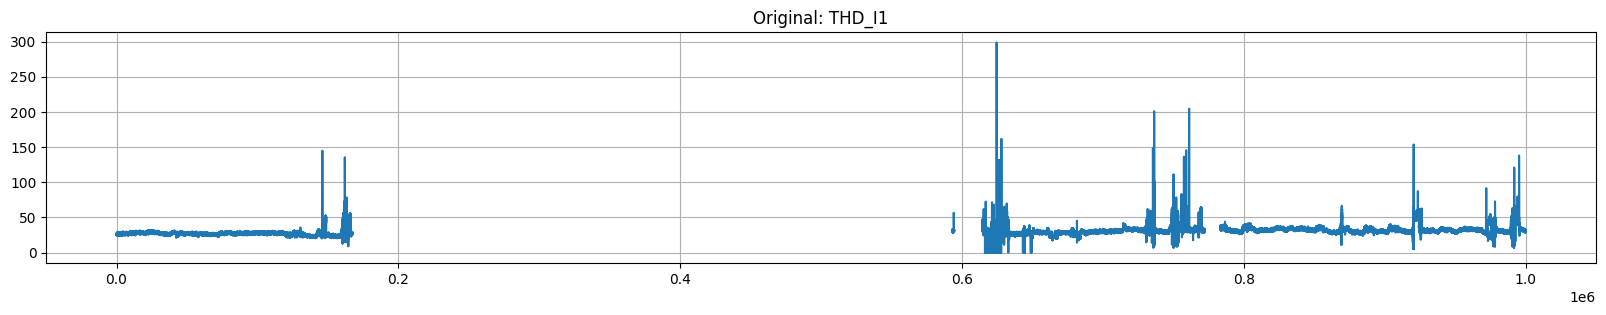

In [63]:
df = pd.read_csv(r"..\dataset_clean\TEC_DMU125MB\THD_I1\2024_THD_I1.csv.xz")

col = df.select_dtypes("number").columns[0]  # first numeric series
print(f"Mean {df[col].mean()} Min {df[col].min()} - Max {df[col].max()}")
plt.figure(figsize=(20, 3))
df[col][0:1000000].plot(title=f"Original: {col}")
plt.grid(True)
plt.show()

EPI_ChipPress


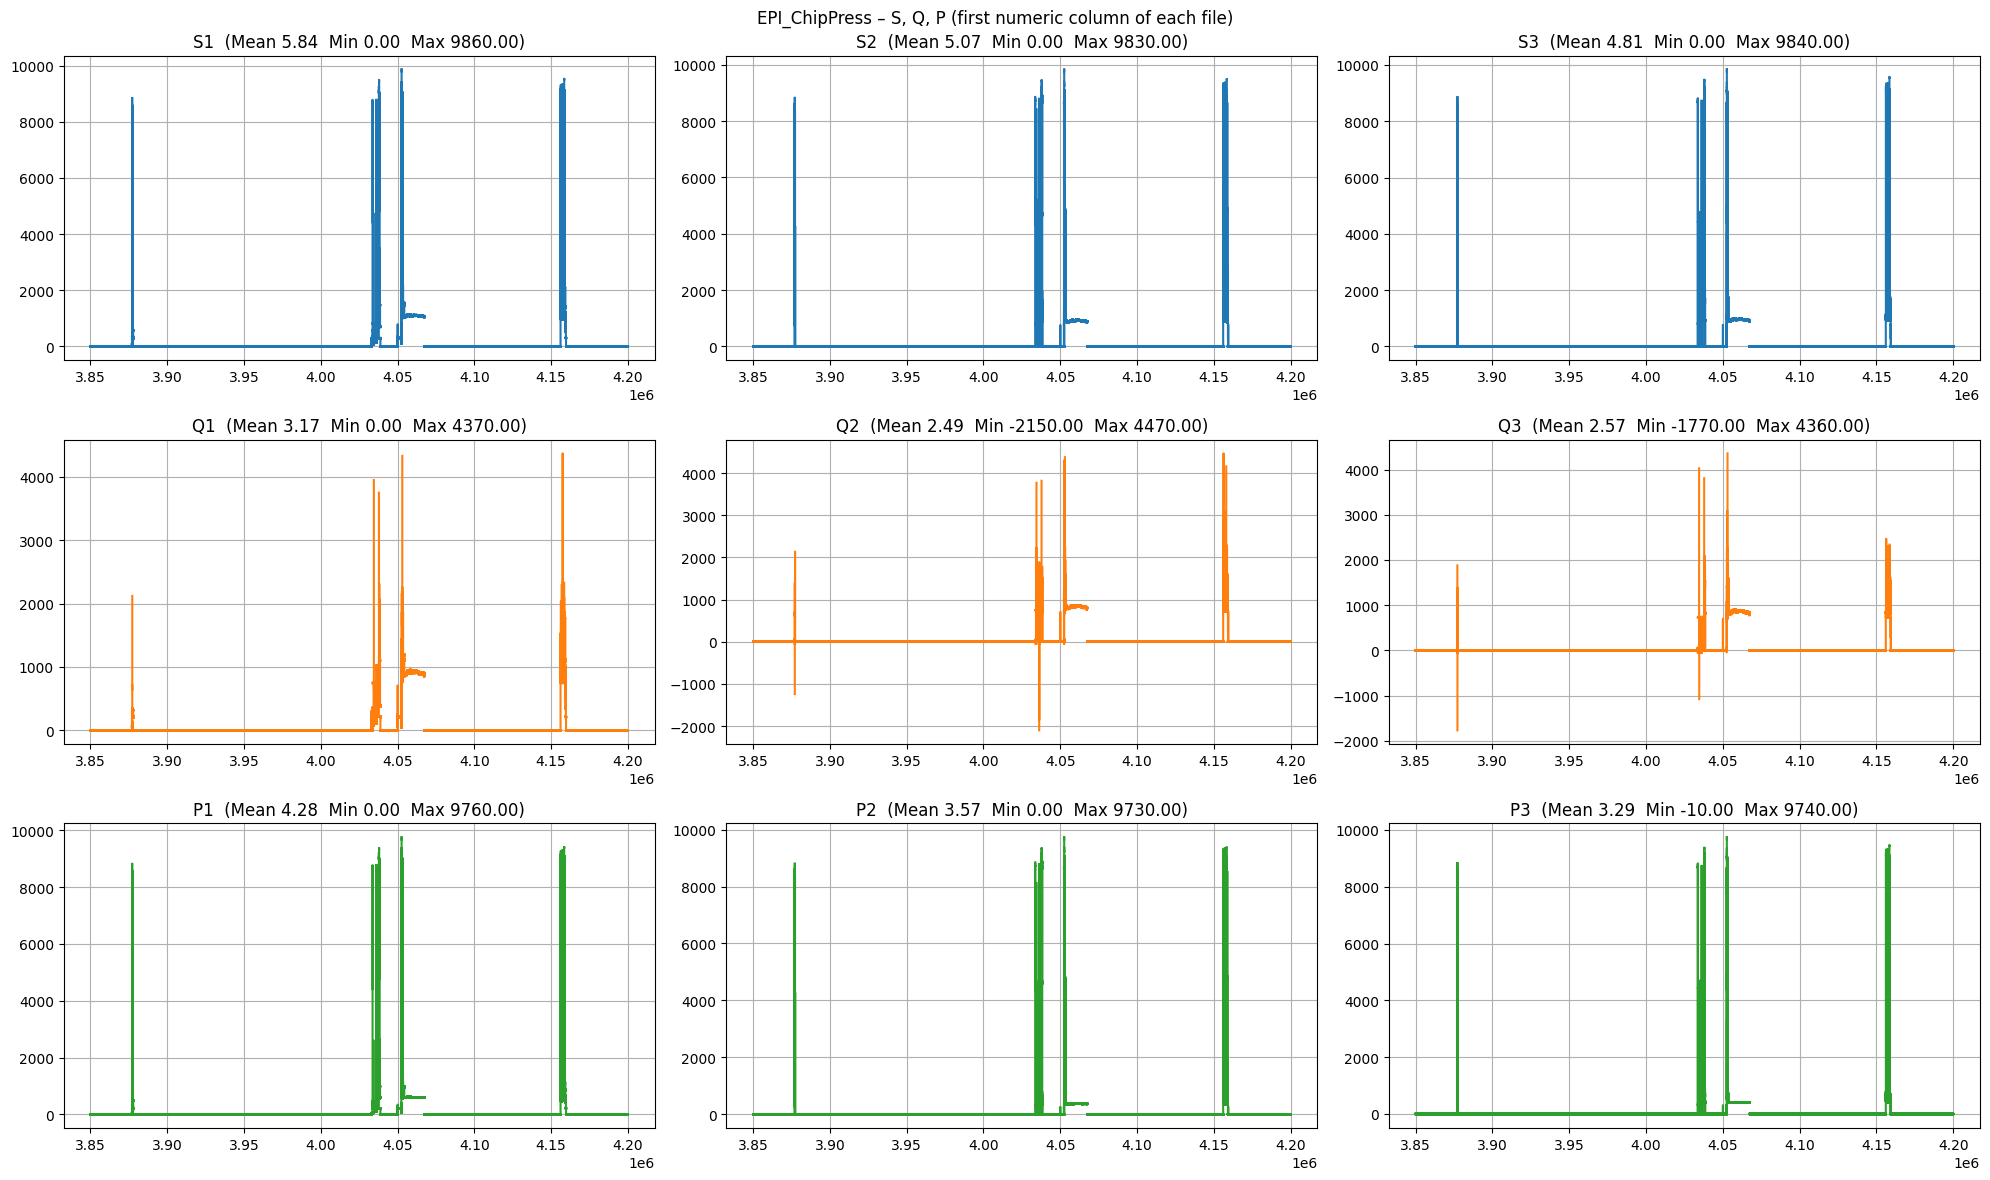

In [35]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def print_and_plot_SQP_rows(
    machine: str = "TEC_48S",
    base_dir: str = r"..\dataset_clean",
    year: str | int = "2024",
    idx_slice: slice | None = slice(0, 7000000),  # set to None for full series
    figsize=(20, 12),
    do_plot: bool = True,
    print_stats: bool = False,
):
    """
    Load S1..S3, Q1..Q3, P1..P3 from:
      ..\\dataset_clean\\<machine>\\<series>\\<year>_<series>.csv.xz
    Print/plot first numeric column of each file.
    Layout: 3 rows x 3 cols (Row 1=S, Row 2=Q, Row 3=P).
    Colors: one distinct color per power type (S, Q, P).
    """

    series_groups = {
        "S": ["S1", "S2", "S3"],
        "Q": ["Q1", "Q2", "Q3"],
        "P": ["P1", "P2", "P3"],
    }

    # One color per power type
    colors = {
        "S": "tab:blue",
        "Q": "tab:orange",
        "P": "tab:green",
    }

    base = Path(base_dir) / machine
    print(machine)

    # Collect data and stats
    data = {g: {} for g in series_groups}
    for grp, ser_list in series_groups.items():
        for ser in ser_list:
            fpath = base / ser / f"{year}_{ser}.csv.xz"
            try:
                if not fpath.exists():
                    print(f"[!] Missing file: {fpath}")
                    data[grp][ser] = None
                    continue

                df = pd.read_csv(fpath)
                num_cols = df.select_dtypes(include="number").columns
                if len(num_cols) == 0:
                    print(f"[!] No numeric columns in {fpath}")
                    data[grp][ser] = None
                    continue

                col = num_cols[0]
                full_series = df[col]
                s = full_series if idx_slice is None else full_series.iloc[idx_slice]

                # Stats on the full series (not just the slice)
                mean_v = float(full_series.mean())
                min_v = float(full_series.min())
                max_v = float(full_series.max())

                if print_stats:
                    print(f"{ser}: Mean {mean_v:.2f}  Min {min_v:.2f}  Max {max_v:.2f}  (col='{col}')")

                data[grp][ser] = {
                    "series": s,
                    "col": col,
                    "mean": mean_v,
                    "min": min_v,
                    "max": max_v,
                }
            except Exception as e:
                print(f"[!] Failed to read {fpath}: {e}")
                data[grp][ser] = None

    if not do_plot:
        return

    # Plot 3 rows x 3 cols
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)
    fig.suptitle(f"{machine} – S, Q, P (first numeric column of each file)", y=0.98)

    def _plot_row(ax_row, grp_key):
        for i, ser in enumerate(series_groups[grp_key]):
            ax = ax_row[i]
            entry = data[grp_key].get(ser)
            if not entry:
                ax.set_title(f"{ser} (missing)")
                ax.grid(True)
                continue
            s = entry["series"]
            mean_v = entry["mean"]
            min_v = entry["min"]
            max_v = entry["max"]
            s.plot(ax=ax, title=f"{ser}  (Mean {mean_v:.2f}  Min {min_v:.2f}  Max {max_v:.2f})",
                   color=colors[grp_key])
            ax.grid(True)

    _plot_row(axes[0], "S")
    _plot_row(axes[1], "Q")
    _plot_row(axes[2], "P")

    plt.tight_layout()
    plt.show()

# EPI_ChipPress EPI_ChipSaw EPI_HighTempOven EPI_PickAndPlace EPI_PumpStation1 EPI_PumpStation2 EPI_ScreenPrinter EPI_SolderOven EPI_TotalLoad EPI_VacuumSoldering EPI_WashingMachine
# TEC_48S TEC_CFST161 TEC_CTX800TC TEC_Chiron800 TEC_DMF3008 TEC_DMU125MB TEC_DNG50evo TEC_E110 TEC_E30D2 TEC_JWA24 TEC_MV2400R
# --- Example execution (three rows; distinct colors for S/Q/P) ---
print_and_plot_SQP_rows(
    machine="EPI_ChipPress",
    base_dir=r"..\dataset_clean",
    year="2024",
    idx_slice=slice(3850000,4200000),  # set None to show full series
    #figsize=(20, 12),
    do_plot=True,
    #print_stats=False,
)


In [36]:
import os
from pathlib import Path
import pandas as pd
import webbrowser

def interactive_SQPUUI_rows(
    machine: str = "TEC_48S",
    base_dir: str = r"..\dataset_clean",
    year: str | int = "2024",
    idx_slice: slice | None = slice(143700, 144000),  # None for full series
    html_path: str | None = None,
    auto_open: bool = True,
    print_stats: bool = False,
):
    """
    Interactive Plotly dashboard (6 rows x 3 cols):
      Row 1: S1, S2, S3
      Row 2: Q1, Q2, Q3
      Row 3: P1, P2, P3
      Row 4: U1, U2, U3
      Row 5: U12, U23, U31
      Row 6: I1, I2, I3
    """

    try:
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
    except ImportError:
        raise ImportError("Plotly is required. Install with: pip install plotly")

    series_groups = {
        "S":     ["S1", "S2", "S3"],
        "Q":     ["Q1", "Q2", "Q3"],
        "P":     ["P1", "P2", "P3"],
        "U":     ["U1", "U2", "U3"],
        "Uline": ["U12", "U23", "U31"],
        "I":     ["I1", "I2", "I3"],
    }
    group_labels = {
        "S": "S",
        "Q": "Q",
        "P": "P",
        "U": "U (phases)",
        "Uline": "U (line-line)",
        "I": "I (phases)",
    }
    colors = {
        "S": "#1f77b4",     # blue
        "Q": "#ff7f0e",     # orange
        "P": "#2ca02c",     # green
        "U": "#d62728",     # red
        "Uline": "#9467bd", # purple
        "I": "#8c564b",     # brown
    }

    base = Path(base_dir) / machine
    data = {g: {} for g in series_groups}

    # Load data
    for grp, ser_list in series_groups.items():
        for ser in ser_list:
            fpath = base / ser / f"{year}_{ser}.csv.xz"
            if not fpath.exists():
                print(f"[!] Missing file: {fpath}")
                data[grp][ser] = None
                continue
            try:
                df = pd.read_csv(fpath)
                num_cols = df.select_dtypes(include="number").columns
                if len(num_cols) == 0:
                    print(f"[!] No numeric columns in {fpath}")
                    data[grp][ser] = None
                    continue

                col = num_cols[0]
                full = df[col]
                series = full if idx_slice is None else full.iloc[idx_slice]

                mean_v = float(full.mean())
                min_v = float(full.min())
                max_v = float(full.max())

                if print_stats:
                    print(f"{ser}: Mean {mean_v:.2f}  Min {min_v:.2f}  Max {max_v:.2f}  (col='{col}')")

                data[grp][ser] = {
                    "series": series,
                    "mean": mean_v,
                    "min": min_v,
                    "max": max_v,
                }
            except Exception as e:
                print(f"[!] Failed to read {fpath}: {e}")
                data[grp][ser] = None

    # --- FIXED TITLES: build them in the exact subplot order ---
    row_order = ["S", "Q", "P", "U", "Uline", "I"]
    titles = []
    for grp in row_order:
        for ser in series_groups[grp]:
            titles.append(f"{group_labels[grp]} — {ser}")

    fig = make_subplots(
        rows=6, cols=3, shared_xaxes=True,
        vertical_spacing=0.06,
        subplot_titles=titles  # now correctly aligned to rows/cols
    )
    row_map = {grp: i+1 for i, grp in enumerate(row_order)}

    # Add traces
    for grp in row_order:
        for ci, ser in enumerate(series_groups[grp], start=1):
            entry = data[grp].get(ser)
            r = row_map[grp]
            c = ci
            if not entry:
                fig.add_trace(
                    go.Scatter(x=[0], y=[0], mode="lines", line=dict(color="#cccccc"),
                               name=f"{ser} (missing)", showlegend=False),
                    row=r, col=c
                )
                continue
            s = entry["series"]
            mean_v, min_v, max_v = entry["mean"], entry["min"], entry["max"]
            fig.add_trace(
                go.Scatter(
                    x=s.index, y=s.values,
                    mode="lines",
                    name=f"{grp} – {ser}",
                    line=dict(color=colors[grp]),
                    legendgroup=grp,
                    hovertemplate=(
                        f"<b>{grp} – {ser}</b><br>"
                        "Index=%{x}<br>"
                        "Value=%{y}<br>"
                        f"Mean={mean_v:.2f}<br>"
                        f"Min={min_v:.2f}<br>"
                        f"Max={max_v:.2f}<extra></extra>"
                    ),
                ),
                row=r, col=c
            )

    fig.update_layout(
        title=f"{machine} — S, Q, P, U(1–3), U(12/23/31), I(1–3) • Interactive",
        height=1600,
        hovermode="x unified",
        dragmode="zoom",
        legend_title_text="Group",
        margin=dict(l=40, r=20, t=70, b=40),
    )
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)

    if html_path is None:
        safe_machine = str(machine).replace(" ", "_")
        html_path = f"{safe_machine}_SQPUUI_interactive.html"

    # Write once; only open once
    fig.write_html(html_path, include_plotlyjs="cdn", full_html=True, auto_open=False)
    if auto_open:
        try:
            webbrowser.open_new_tab(Path(html_path).resolve().as_uri())
        except Exception:
            pass

    return html_path

machines = ["EPI_ChipPress", "EPI_ChipSaw", "EPI_HighTempOven", "EPI_TotalLoad", "TEC_CFST161", "TEC_E110", "TEC_DMU125MB"]
# EPI_ChipPress EPI_ChipSaw EPI_HighTempOven EPI_PickAndPlace EPI_PumpStation1 EPI_PumpStation2 EPI_ScreenPrinter EPI_SolderOven EPI_TotalLoad EPI_VacuumSoldering EPI_WashingMachine
# TEC_48S TEC_CFST161 TEC_CTX800TC TEC_Chiron800 TEC_DMF3008 TEC_DMU125MB TEC_DNG50evo TEC_E110 TEC_E30D2 TEC_JWA24 TEC_MV2400R


interactive_SQPUUI_rows(
    machine="EPI_ChipPress",
    base_dir=r"..\dataset_clean",
    year="2024",
    idx_slice=slice(3850000,4200000),  # None for full span
)

'EPI_ChipPress_SQPUUI_interactive.html'

# Validate Power Measures
- Assume for EPI: P_total = P1+P2+P3, Q_total_vec = Q1+Q2+Q3, S_total_vec = S1+S2+S3, PF_total_vec = 1/3(PF1+PF2+PF3)

In [167]:
from pathlib import Path
import pandas as pd
import math

def check_four_aggregates(
    root: str | Path = "../dataset_clean",
    *,
    years_considered = (2018, 2019, 2024),
    abs_tol: float = 1e-3,
    rel_tol: float = 0.02,
    exclude_if_name_contains=("PV",),
):
    """
    For each machine and selected year (only where the needed files exist), compute means of the first numeric column
    and evaluate:
      1) P_total ≈ P1+P2+P3
      2) Q_total_vec ≈ candidate in {sum(Qk), rss(Qk)}
      3) S_total_vec ≈ candidate in {sqrt((sum Pk)^2 + (sum Qk)^2), rss(Sk), sum(Sk)}
      4) PF_total_vec ≈ candidate in { (sum Pk)/Svec_from_PQ , mean(PFk) }
    Prints compact evaluations and returns a list of dict results.
    """
    root = Path(root)
    if not root.is_dir():
        print(f"[ERROR] Data root not found: {root}")
        return []

    allowed_years = set(int(y) for y in years_considered)

    def _skip(name: str) -> bool:
        low = name.lower()
        return any(tag.lower() in low for tag in (exclude_if_name_contains or ()))

    def _first_numeric_mean(path: Path):
        try:
            df = pd.read_csv(path)
        except Exception:
            return None
        num = df.select_dtypes("number")
        if num.empty:
            return None
        s = pd.to_numeric(num.iloc[:, 0], errors="coerce")
        return float(s.mean()) if s.notna().any() else None

    def _years_for(machine_dir: Path, meas: str) -> set[int]:
        mdir = machine_dir / meas
        if not mdir.is_dir():
            return set()
        yrs = set()
        for f in mdir.glob(f"*_{meas}.csv.xz"):
            try:
                yrs.add(int(f.name.split("_", 1)[0]))
            except Exception:
                pass
        return yrs & allowed_years

    def _get_mean(machine_dir: Path, meas: str, year: int):
        p = machine_dir / meas / f"{year}_{meas}.csv.xz"
        return _first_numeric_mean(p) if p.exists() else None

    def _ok(diff, ref):
        thr = max(abs_tol, rel_tol * abs(ref) if ref is not None else abs_tol)
        return (diff is not None) and (abs(diff) <= thr)

    machines = sorted(d for d in root.iterdir() if d.is_dir() and not _skip(d.name))
    if not machines:
        print("[INFO] No machines after exclusions.")
        return []

    results = []
    print("machine/year  aggregate  observed  |  components(means)  ->  candidates  |  diff/best  status")

    for mach in machines:
        required_sets = {
            "P":  {"P_total","P1","P2","P3"},
            "Qv": {"Q_total_vec","Q1","Q2","Q3"},
            "Sv": {"S_total_vec","S1","S2","S3","P1","P2","P3","Q1","Q2","Q3"},
            "PF": {"PF_total_vec","PF1","PF2","PF3","S1","S2","S3","P1","P2","P3","Q1","Q2","Q3"},
        }
        years_by_meas = {m: _years_for(mach, m) for ms in required_sets.values() for m in ms}

        # 1) P_total
        years = years_by_meas.get("P_total", set()) & years_by_meas.get("P1", set()) & years_by_meas.get("P2", set()) & years_by_meas.get("P3", set())
        for y in sorted(years):
            Ptot = _get_mean(mach, "P_total", y)
            P1 = _get_mean(mach, "P1", y); P2 = _get_mean(mach, "P2", y); P3 = _get_mean(mach, "P3", y)
            if None in (Ptot, P1, P2, P3): continue
            sumP = P1 + P2 + P3
            diff = Ptot - sumP
            status = "OK" if _ok(diff, sumP) else "INVALID"
            print(f"{mach.name}/{y}  P_total    {Ptot:.6g} | P1={P1:.6g},P2={P2:.6g},P3={P3:.6g}  -> sum={sumP:.6g} | Δ={diff:.3g}  {status}")
            results.append({"machine": mach.name, "year": y, "agg": "P_total",
                            "observed": Ptot, "components": {"P1":P1,"P2":P2,"P3":P3},
                            "candidates": {"sum": sumP}, "best": "sum", "diff": diff, "status": status})

        # 2) Q_total_vec
        years = years_by_meas.get("Q_total_vec", set()) & years_by_meas.get("Q1", set()) & years_by_meas.get("Q2", set()) & years_by_meas.get("Q3", set())
        for y in sorted(years):
            Qv = _get_mean(mach, "Q_total_vec", y)
            Q1 = _get_mean(mach, "Q1", y); Q2 = _get_mean(mach, "Q2", y); Q3 = _get_mean(mach, "Q3", y)
            if None in (Qv, Q1, Q2, Q3): continue
            cand_sum = Q1 + Q2 + Q3
            cand_rss = math.sqrt(Q1*Q1 + Q2*Q2 + Q3*Q3)
            diffs = {"sum": Qv - cand_sum, "rss": Qv - cand_rss}
            best = min(diffs, key=lambda k: abs(diffs[k]))
            status = "OK" if _ok(diffs[best], cand_sum if best=="sum" else cand_rss) else "INVALID"
            print(f"{mach.name}/{y}  Q_total_vec {Qv:.6g} | Q1={Q1:.6g},Q2={Q2:.6g},Q3={Q3:.6g} -> sum={cand_sum:.6g}, rss={cand_rss:.6g} | best={best}, Δ={diffs[best]:.3g}  {status}")
            results.append({"machine": mach.name, "year": y, "agg": "Q_total_vec",
                            "observed": Qv, "components": {"Q1":Q1,"Q2":Q2,"Q3":Q3},
                            "candidates": {"sum": cand_sum, "rss": cand_rss},
                            "best": best, "diff": diffs[best], "status": status})

        # 3) S_total_vec  (now includes 'sumS' candidate)
        need = {"S_total_vec","S1","S2","S3","P1","P2","P3","Q1","Q2","Q3"}
        years = set.intersection(*(years_by_meas.get(m,set()) for m in need)) if all(m in years_by_meas for m in need) else set()
        for y in sorted(years):
            Sv = _get_mean(mach, "S_total_vec", y)
            S1 = _get_mean(mach, "S1", y); S2 = _get_mean(mach, "S2", y); S3 = _get_mean(mach, "S3", y)
            P1 = _get_mean(mach, "P1", y); P2 = _get_mean(mach, "P2", y); P3 = _get_mean(mach, "P3", y)
            Q1 = _get_mean(mach, "Q1", y); Q2 = _get_mean(mach, "Q2", y); Q3 = _get_mean(mach, "Q3", y)
            if None in (Sv,S1,S2,S3,P1,P2,P3,Q1,Q2,Q3): continue
            sumP = P1+P2+P3; sumQ = Q1+Q2+Q3; sumS = S1+S2+S3
            cand_fromPQ = math.sqrt(sumP*sumP + sumQ*sumQ)
            cand_rssS   = math.sqrt(S1*S1 + S2*S2 + S3*S3)
            cand_sumS   = sumS
            diffs = {"from_PQ": Sv - cand_fromPQ, "rss_S": Sv - cand_rssS, "sumS": Sv - cand_sumS}
            best = min(diffs, key=lambda k: abs(diffs[k]))
            ref = {"from_PQ": cand_fromPQ, "rss_S": cand_rssS, "sumS": cand_sumS}[best]
            status = "OK" if _ok(diffs[best], ref) else "INVALID"
            print(f"{mach.name}/{y}  S_total_vec {Sv:.6g} | S1={S1:.6g},S2={S2:.6g},S3={S3:.6g} -> "
                  f"fromPQ={cand_fromPQ:.6g}, rssS={cand_rssS:.6g}, sumS={cand_sumS:.6g} | best={best}, Δ={diffs[best]:.3g}  {status}")
            results.append({"machine": mach.name, "year": y, "agg": "S_total_vec",
                            "observed": Sv,
                            "components": {"S1":S1,"S2":S2,"S3":S3,"sumP":sumP,"sumQ":sumQ},
                            "candidates": {"from_PQ": cand_fromPQ, "rss_S": cand_rssS, "sumS": cand_sumS},
                            "best": best, "diff": diffs[best], "status": status})

        # 4) PF_total_vec  (weighted option removed)
        need = {"PF_total_vec","PF1","PF2","PF3","S1","S2","S3","P1","P2","P3","Q1","Q2","Q3"}
        years = set.intersection(*(years_by_meas.get(m,set()) for m in need)) if all(m in years_by_meas for m in need) else set()
        for y in sorted(years):
            PFv = _get_mean(mach, "PF_total_vec", y)
            PF1 = _get_mean(mach, "PF1", y); PF2 = _get_mean(mach, "PF2", y); PF3 = _get_mean(mach, "PF3", y)
            S1 = _get_mean(mach, "S1", y); S2 = _get_mean(mach, "S2", y); S3 = _get_mean(mach, "S3", y)
            P1 = _get_mean(mach, "P1", y); P2 = _get_mean(mach, "P2", y); P3 = _get_mean(mach, "P3", y)
            Q1 = _get_mean(mach, "Q1", y); Q2 = _get_mean(mach, "Q2", y); Q3 = _get_mean(mach, "Q3", y)
            if None in (PFv,PF1,PF2,PF3,S1,S2,S3,P1,P2,P3,Q1,Q2,Q3): continue
            sumP = P1+P2+P3; sumQ = Q1+Q2+Q3
            Svec_fromPQ = math.sqrt(sumP*sumP + sumQ*sumQ)
            cand_P_over_Svec = (sumP / Svec_fromPQ) if Svec_fromPQ != 0 else float("nan")
            cand_meanPF      = (PF1 + PF2 + PF3) / 3.0
            candidates = {"P_over_Svec": cand_P_over_Svec, "mean_PF": cand_meanPF}
            diffs = {k: (PFv - v) if (v is not None and not math.isnan(v)) else float("inf") for k,v in candidates.items()}
            best = min(diffs, key=lambda k: abs(diffs[k]))
            ref = candidates[best]
            status = "OK" if (ref is not None and not math.isnan(ref) and _ok(diffs[best], ref)) else "INVALID"
            print(f"{mach.name}/{y}  PF_total_vec {PFv:.6g} | PF1={PF1:.6g},PF2={PF2:.6g},PF3={PF3:.6g} -> "
                  f"P/Svec={cand_P_over_Svec:.6g}, mean={cand_meanPF:.6g} | best={best}, Δ={diffs[best]:.3g}  {status}")
            results.append({"machine": mach.name, "year": y, "agg": "PF_total_vec",
                            "observed": PFv,
                            "components": {"PF1":PF1,"PF2":PF2,"PF3":PF3,"S1":S1,"S2":S2,"S3":S3,"sumP":sumP,"sumQ":sumQ},
                            "candidates": candidates, "best": best, "diff": diffs[best], "status": status})

    return results

# --- Example execution (uncomment to run) ---
results = check_four_aggregates(
    root="../dataset_clean",
    years_considered=(2018, 2019, 2020, 2021, 2022, 2023, 2024),
    abs_tol=1e-3,
    rel_tol=0.02,
)

machine/year  aggregate  observed  |  components(means)  ->  candidates  |  diff/best  status
EPI_ChipPress/2018  P_total    242.644 | P1=-24.5303,P2=-25.9503,P3=-22.0234  -> sum=-72.5039 | Δ=315  INVALID
EPI_ChipPress/2019  P_total    119.009 | P1=43.6636,P2=40.7121,P3=34.6331  -> sum=119.009 | Δ=-0.000112  OK
EPI_ChipPress/2020  P_total    27.6068 | P1=11.2007,P2=9.03757,P3=7.36845  -> sum=27.6068 | Δ=4.22e-05  OK
EPI_ChipPress/2021  P_total    22.6042 | P1=8.46551,P2=7.72644,P3=6.41183  -> sum=22.6038 | Δ=0.00042  OK
EPI_ChipPress/2022  P_total    35.4001 | P1=12.7182,P2=12.0332,P3=10.6487  -> sum=35.4 | Δ=6.79e-05  OK
EPI_ChipPress/2023  P_total    29.5962 | P1=12.615,P2=9.10356,P3=7.8782  -> sum=29.5968 | Δ=-0.000571  OK
EPI_ChipPress/2024  P_total    11.138 | P1=4.27641,P2=3.57311,P3=3.29129  -> sum=11.1408 | Δ=-0.00281  OK
EPI_ChipPress/2018  Q_total_vec -31.0868 | Q1=-11.6594,Q2=-9.80038,Q3=-10.1446 -> sum=-31.6045, rss=18.3004 | best=sum, Δ=0.518  OK
EPI_ChipPress/2019  Q_tota

In [40]:
from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np
import math
from typing import Dict, Tuple, Optional, Iterable

def validate_power_limits(
    root: str | Path = "../dataset_clean",
    *,
    machines_to_analyze: Optional[Iterable[str]] = None,   # e.g. ("EPI_ChipPress","TEC_DMF3008")
    years_considered: Iterable[int] = (2018, 2019, 2024),
    measurements: Iterable[str] = (
        "U1","U2","U3","U12","U23","U31",
        "I1","I2","I3","IN","I_sys",
        "P1","P2","P3","P_total",
        "S1","S2","S3","S_total_vec",
        "Q1","Q2","Q3","Q_total_vec",
    ),
    exclude_if_name_contains: Iterable[str] = ("PV",),
    safety_margin: float = 1.15,       # multiplier on rated currents/powers to avoid false positives
    regen_fraction: float = 0.10,      # allow small negative P due to regeneration
    treat_missing_as_outlier: bool = True,
    return_limits_only: bool = False,  # set True to only build & return the limits DataFrame
) -> dict:
    """
    Build allowed [min,max] ranges per machine×measurement and (optionally) validate files.

    Voltage ranges (fixed by standard tolerances):
      • U1,U2,U3: 230 V ±10%  -> [207, 253] V
      • U12,U23,U31: 400 V ±10% -> [360, 440] V

    Current ranges (from rated current with safety margin):
      • I1,I2,I3 ∈ [0, safety_margin·rated_I]
      • IN       ∈ [0, safety_margin·rated_I]          (worst-case unbalance bound)
      • I_sys    ∈ [0, safety_margin·√3·rated_I]

    Apparent power (from rated voltage & current):
      • 3φ: S_total_max = safety_margin·(√3·V_LL·rated_I), S_phase_max = safety_margin·(V_LN·rated_I), V_LN=V_LL/√3
      • 1φ: S_total_max = safety_margin·(V·rated_I),        S_phase_max = S_total_max

      Limits: S1,S2,S3 ∈ [0, S_phase_max],  S_total_vec ∈ [0, S_total_max]

    Active power (allow small regeneration; bounded by S):
      • P_phase ∈ [−regen_fraction·S_phase_max, +S_phase_max]
      • P_total ∈ [−regen_fraction·S_total_max, +S_total_max]
        (Consistency: P_total = P1+P2+P3 — checked only in data, not in limit construction)

    Reactive power (bounded by S):
      • Q_phase ∈ [−S_phase_max, +S_phase_max]
      • Q_total ∈ [−S_total_max, +S_total_max]
        (Consistency: Q_total_vec = Q1+Q2+Q3 — checked only in data)
    """
    root = Path(root)
    years_allowed = set(int(y) for y in years_considered)

    # ---------- Single consolidated machine spec map: directory -> (phase_system, rated_line_voltage_V, rated_current_A)
    # If rated_current is None, current- and power-based ranges cannot be computed (voltages still provided).
    DIRECTORY_SPECS: Dict[str, Tuple[str, float, Optional[float]]] = {
        # EPI
        "EPI_ChipPress":          ("3P", 400.0, 50.0),
        "EPI_ChipSaw":            ("3P", 400.0, 6.0),
        "EPI_HighTempOven":       ("3P", 400.0, 32.0),
        "EPI_PickAndPlace":       ("1P", 230.0, 5.0),
        "EPI_PumpStation1":       ("3P", 400.0, 34),#estimate
        "EPI_PumpStation2":       ("3P", 400.0, 36),#estimate
        "EPI_ScreenPrinter":      ("1P", 400.0, 5.2),
        "EPI_SolderOven":         ("3P", 400.0, 29.0),
        "EPI_TotalLoad":          ("3P", 400.0, 160),#estimate
        "EPI_VacuumSoldering":    ("3P", 400.0, 14.0),  # (2x14A,1x7A) → conservative per-phase 14 A
        "EPI_WashingMachine":     ("3P", 400.0, 18),#estimate
        # TEC
        "TEC_48S":                ("3P", 400.0, 35.0),
        "TEC_CFST161":            ("3P", 400.0, 31.0),
        "TEC_CTX800TC":           ("3P", 400.0, 100.0),
        "TEC_Chiron800":          ("3P", 400.0, 56.0),
        "TEC_DMF3008":            ("3P", 400.0, 80.0),
        "TEC_DMU125MB":           ("3P", 400.0, 125.0),
        "TEC_DNG50evo":           ("3P", 400.0, 80.0),
        "TEC_E110":               ("3P", 400.0, 80.0),
        "TEC_E30D2":              ("3P", 400.0, 15.0),
        "TEC_JWA24":              ("3P", 400.0, 20.0),
        "TEC_MV2400R":            ("3P", 400.0, 35.0),
    }

    # If machines_to_analyze provided, restrict to those; else include all present under root (minus excluded).
    def _is_excluded(name: str) -> bool:
        low = name.lower()
        return any(tag.lower() in low for tag in (exclude_if_name_contains or ()))

    if machines_to_analyze is None:
        candidate_dirs = [d.name for d in root.iterdir() if d.is_dir() and not _is_excluded(d.name)]
    else:
        candidate_dirs = [m for m in machines_to_analyze if not _is_excluded(m)]

    # Keep only those that exist on disk (so paths resolve) but still compute limits for any in DIRECTORY_SPECS if needed.
    existing_dirs = {d.name for d in root.iterdir() if d.is_dir()}
    machines = [m for m in candidate_dirs if (m in existing_dirs or m in DIRECTORY_SPECS)]

    # ---------------- Fixed voltage windows by standard tolerances (do not depend on rated_current)
    U_PHASE_MIN, U_PHASE_MAX = 207.0, 253.0   # 230V ±10% for U1,U2,U3
    U_LINE_MIN,  U_LINE_MAX  = 360.0, 440.0   # 400V ±10% for U12,U23,U31

    # -------- Helpers to compute numeric bounds + short rationale notes (to include in output DF)
    def compute_bounds_for_machine(
        phase_system: str, rated_V_line: float, rated_I: Optional[float]
    ) -> Dict[str, Tuple[float, float, str]]:
        bounds: Dict[str, Tuple[float, float, str]] = {}

        # Voltages (always available)
        for m in ("U1","U2","U3"):  bounds[m] = (U_PHASE_MIN, U_PHASE_MAX, "230V ±10%")
        for m in ("U12","U23","U31"): bounds[m] = (U_LINE_MIN,  U_LINE_MAX,  "400V ±10%")

        if rated_I is None:
            return bounds  # can't compute current- or power-based limits

        # Currents
        I_max_phase = safety_margin * rated_I
        I_max_sys   = safety_margin * math.sqrt(3.0) * rated_I
        for m in ("I1","I2","I3"): bounds[m] = (0.0, I_max_phase, "≤ safety_margin·rated_I")
        bounds["IN"]    = (0.0, I_max_phase, "Neutral ≤ safety_margin·rated_I")
        bounds["I_sys"] = (0.0, I_max_sys,   "System ≤ safety_margin·√3·rated_I")

        # Apparent power
        if phase_system.upper() == "3P":
            V_LL = rated_V_line
            V_LN = V_LL / math.sqrt(3.0)
            S_total_max = safety_margin * (math.sqrt(3.0) * V_LL * rated_I)
            S_phase_max = safety_margin * (V_LN * rated_I)
            s_tot_note  = "≤ safety_margin·√3·V_LL·rated_I"
            s_ph_note   = "≤ safety_margin·V_LN·rated_I"
        else:  # 1P
            V = rated_V_line
            S_total_max = safety_margin * (V * rated_I)
            S_phase_max = S_total_max
            s_tot_note  = "≤ safety_margin·V·rated_I (1φ)"
            s_ph_note   = "≤ safety_margin·V·rated_I (1φ)"

        for m in ("S1","S2","S3"): bounds[m] = (0.0, S_phase_max, s_ph_note)
        bounds["S_total_vec"] = (0.0, S_total_max, s_tot_note + "; S_total_vec = ΣSφ")

        # Active power (allow small negative due to regeneration)
        P_ph_min, P_ph_max   = (-regen_fraction * S_phase_max, S_phase_max)
        P_tot_min, P_tot_max = (-regen_fraction * S_total_max, S_total_max)
        p_ph_note  = "∈ [−regen_fraction·S_phase_max, +S_phase_max]"
        p_tot_note = "∈ [−regen_fraction·S_total_max, +S_total_max]; P_total = ΣPφ"
        for m in ("P1","P2","P3"): bounds[m] = (P_ph_min, P_ph_max, p_ph_note)
        bounds["P_total"]     = (P_tot_min, P_tot_max, p_tot_note)

        # Reactive power (bounded by S)
        Q_ph_min, Q_ph_max   = (-S_phase_max, S_phase_max)
        Q_tot_min, Q_tot_max = (-S_total_max, S_total_max)
        q_ph_note = "∈ [−S_phase_max, +S_phase_max]"
        q_tot_note = "∈ [−S_total_max, +S_total_max]; Q_total_vec = ΣQφ"
        for m in ("Q1","Q2","Q3"): bounds[m] = (Q_ph_min, Q_ph_max, q_ph_note)
        bounds["Q_total_vec"] = (Q_tot_min, Q_tot_max, q_tot_note)

        return bounds

    # -------- Build limits table (machine×measurement) and a nested lookup
    limit_rows = []
    limits_by_dir: Dict[str, Dict[str, Tuple[float, float]]] = {}
    for machine in machines:
        spec = DIRECTORY_SPECS.get(machine)
        if spec is None:
            # Unknown specs → only voltage ranges are known
            b = {m: (U_PHASE_MIN, U_PHASE_MAX, "230V ±10%") for m in ("U1","U2","U3")}
            b |= {m: (U_LINE_MIN, U_LINE_MAX,  "400V ±10%") for m in ("U12","U23","U31")}
        else:
            phases, rated_V_line, rated_I = spec
            b = compute_bounds_for_machine(phases, rated_V_line, rated_I)

        # Store for quick lookup (min,max only)
        limits_by_dir[machine] = {k: (v[0], v[1]) for k, v in b.items()}

        # Append rows limited to requested measurements
        for meas in measurements:
            if meas in b:
                lo, hi, note = b[meas]
                limit_rows.append({
                    "machine_dir": machine,
                    "measurement": meas,
                    "min_allowed": lo,
                    "max_allowed": hi,
                    "rationale": note,
                })

    limits_df = pd.DataFrame(limit_rows).sort_values(["machine_dir","measurement"]).reset_index(drop=True)

    if return_limits_only:
        return {"limits_df": limits_df, "limits_by_dir": limits_by_dir, "per_machine": {}, "global": {}}

    # -------- Validation helpers
    def years_available(machine_dir: Path, meas: str) -> set[int]:
        d = machine_dir / meas
        if not d.is_dir():
            return set()
        years = set()
        for f in d.glob(f"*_{meas}.csv.xz"):
            try:
                years.add(int(f.name.split("_", 1)[0]))
            except Exception:
                pass
        return years & years_allowed

    def first_numeric_minmax(csv_path: Path) -> Tuple[Optional[float], Optional[float]]:
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            return None, None
        num = df.select_dtypes("number")
        if num.empty:
            return None, None
        s = pd.to_numeric(num.iloc[:, 0], errors="coerce").dropna()
        if s.empty:
            return None, None
        return float(s.min()), float(s.max())

    # -------- Show limits (small excerpt) and validate against files
    print("=== Allowed ranges (excerpt) ===")
    with pd.option_context("display.max_rows", 20, "display.width", 140):
        print(limits_df.head(20))

    print("\n=== Data vs limits (min..max in data | allowed min..max) ===")
    global_ok = global_out = global_unknown = 0
    per_machine_summary: Dict[str, Dict[str,int]] = {}

    for machine in machines:
        mach_dir_path = root / machine
        per_machine_summary.setdefault(machine, {"OK":0, "OUTLIER":0, "UNKNOWN":0})
        lims = limits_by_dir.get(machine)

        for meas in measurements:
            for y in sorted(years_available(mach_dir_path, meas)):
                p = mach_dir_path / meas / f"{y}_{meas}.csv.xz"
                vmin, vmax = first_numeric_minmax(p)

                if vmin is None or vmax is None:
                    status = "OUTLIER" if treat_missing_as_outlier else "UNKNOWN"
                    allowed = "n/a"
                elif (lims is None) or (meas not in lims):
                    status = "OUTLIER" if treat_missing_as_outlier else "UNKNOWN"
                    allowed = "n/a"
                else:
                    lo, hi = lims[meas]
                    status = "OK" if (vmin >= lo and vmax <= hi) else "OUTLIER"
                    allowed = f"{lo:.6g}..{hi:.6g}"

                per_machine_summary[machine][status] += 1
                if status == "OK": global_ok += 1
                elif status == "OUTLIER": global_out += 1
                else: global_unknown += 1

                data_rng = "n/a" if (vmin is None or vmax is None) else f"{vmin:.6g}..{vmax:.6g}"
                # FULL copyable path, as requested:
                print(f"{p}  {data_rng:<20} | {allowed:<20} {status}")

    print("\n=== Summary per machine ===")
    for m, c in sorted(per_machine_summary.items()):
        print(f"{m}: OK={c['OK']}, OUTLIER={c['OUTLIER']}, UNKNOWN={c['UNKNOWN']}")

    print(f"\n=== Global summary ===\nOK={global_ok}, OUTLIER={global_out}, UNKNOWN={global_unknown}")

    return {
        "limits_df": limits_df,
        "limits_by_dir": limits_by_dir,
        "per_machine": per_machine_summary,
        "global": {"OK": global_ok, "OUTLIER": global_out, "UNKNOWN": global_unknown},
    }

# --- Example execution (you can tweak machines_to_analyze) ---
result = validate_power_limits(
    root="../dataset_clean",
    machines_to_analyze=(
        "EPI_ChipPress",
        "EPI_ChipSaw",
        "EPI_HighTempOven",
        "EPI_PickAndPlace",
        "EPI_PumpStation1",
        "EPI_PumpStation2",
        "EPI_ScreenPrinter",
        "EPI_SolderOven",
        "EPI_TotalLoad",
        "EPI_VacuumSoldering",
        "EPI_WashingMachine",
        "TEC_48S",
        "TEC_CFST161",
        "TEC_CTX800TC",
        "TEC_Chiron800",
        "TEC_DMF3008",
        "TEC_DMU125MB",
        "TEC_DNG50evo",
        "TEC_E110",
        "TEC_E30D2",
        "TEC_JWA24",
        "TEC_MV2400R",
    ),
    years_considered=(2018, 2019, 2020, 2021, 2022, 2023, 2024),
    safety_margin=1.15,
    regen_fraction=0.10,
    treat_missing_as_outlier=True,
)


=== Allowed ranges (excerpt) ===
      machine_dir  measurement   min_allowed   max_allowed                                          rationale
0   EPI_ChipPress           I1      0.000000     57.500000                            ≤ safety_margin·rated_I
1   EPI_ChipPress           I2      0.000000     57.500000                            ≤ safety_margin·rated_I
2   EPI_ChipPress           I3      0.000000     57.500000                            ≤ safety_margin·rated_I
3   EPI_ChipPress           IN      0.000000     57.500000                    Neutral ≤ safety_margin·rated_I
4   EPI_ChipPress        I_sys      0.000000     99.592921                  System ≤ safety_margin·√3·rated_I
5   EPI_ChipPress           P1  -1327.905619  13279.056191      ∈ [−regen_fraction·S_phase_max, +S_phase_max]
6   EPI_ChipPress           P2  -1327.905619  13279.056191      ∈ [−regen_fraction·S_phase_max, +S_phase_max]
7   EPI_ChipPress           P3  -1327.905619  13279.056191      ∈ [−regen_fraction·S_ph

Mean 22.022222954929866 Min 2.76 - Max 134.448


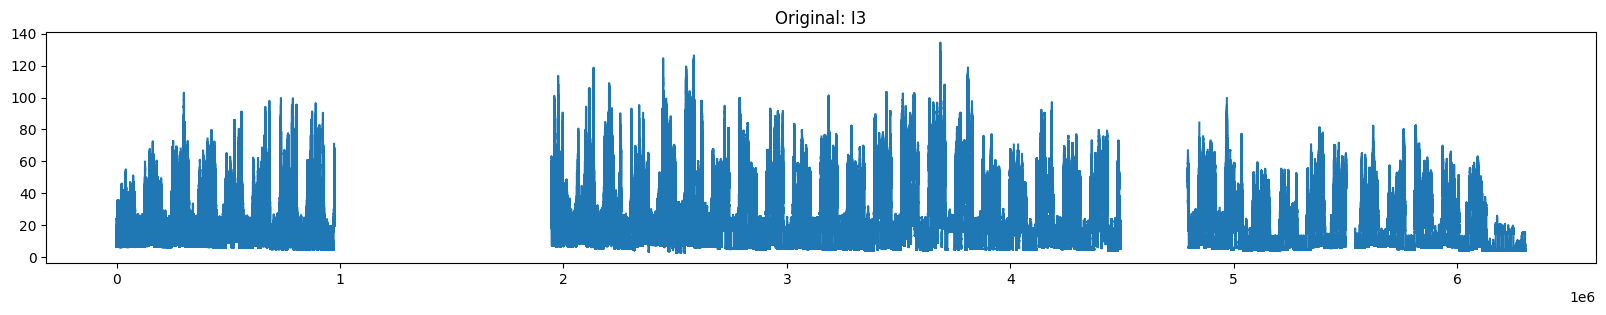

In [181]:
df = pd.read_csv(r"..\dataset_clean\EPI_TotalLoad\I3\2018_I3.csv.xz")
col = df.select_dtypes("number").columns[0]  # first numeric series
print(f"Mean {df[col].mean()} Min {df[col].min()} - Max {df[col].max()}")
plt.figure(figsize=(20, 3))
df[col].plot(title=f"Original: {col}")
plt.show()

In [41]:
def validate_power_limits(
    root: str | Path = "../dataset_clean",
    *,
    machines_to_analyze: Optional[Iterable[str]] = None,   # e.g. ("EPI_ChipPress","TEC_DMF3008")
    years_considered: Iterable[int] = (2018, 2019, 2024),
    measurements: Iterable[str] = (
        "U1","U2","U3","U12","U23","U31",
        "I1","I2","I3","IN","I_sys",
        "P1","P2","P3","P_total",
        "S1","S2","S3","S_total_vec",
        "Q1","Q2","Q3","Q_total_vec",
    ),
    exclude_if_name_contains: Iterable[str] = ("PV",),
    safety_margin: float = 1.15,       # multiplier on rated currents/powers to avoid false positives
    regen_fraction: float = 0.10,      # kept for compatibility; no longer used for P lower bounds
    treat_missing_as_outlier: bool = True,
    return_limits_only: bool = False,  # set True to only build & return the limits DataFrame
) -> dict:
    """
    Build allowed [min,max] ranges per machine×measurement and (optionally) validate files.

    Voltage ranges (fixed by standard tolerances):
      • U1,U2,U3: 230 V ±10%  -> [207, 253] V
      • U12,U23,U31: 400 V ±10% -> [360, 440] V

    Current ranges (from rated current with safety margin):
      • I1,I2,I3 ∈ [0, safety_margin·rated_I]
      • IN       ∈ [0, safety_margin·rated_I]          (worst-case unbalance bound)
      • I_sys    ∈ [0, safety_margin·√3·rated_I]

    Apparent power (from rated voltage & current):
      • 3φ: S_total_max = safety_margin·(√3·V_LL·rated_I), S_phase_max = safety_margin·(V_LN·rated_I), V_LN=V_LL/√3
      • 1φ: S_total_max = safety_margin·(V·rated_I),        S_phase_max = S_total_max

      Limits: S1,S2,S3 ∈ [0, S_phase_max],  S_total_vec ∈ [0, S_total_max]

    Active power (symmetric bounds using S, allowing full regeneration up to S):
      • P_phase ∈ [−S_phase_max, +S_phase_max]
      • P_total ∈ [−S_total_max, +S_total_max]
        (Consistency: P_total = P1+P2+P3 — checked only in data, not in limit construction)
      NOTE: `regen_fraction` is not used for P lower bounds anymore.

    Reactive power (bounded by S):
      • Q_phase ∈ [−S_phase_max, +S_phase_max]
      • Q_total ∈ [−S_total_max, +S_total_max]
        (Consistency: Q_total_vec = Q1+Q2+Q3 — checked only in data)
    """
    root = Path(root)
    years_allowed = set(int(y) for y in years_considered)

    # ---------- Single consolidated machine spec map: directory -> (phase_system, rated_line_voltage_V, rated_current_A)
    # If rated_current is None, current- and power-based ranges cannot be computed (voltages still provided).
    DIRECTORY_SPECS: Dict[str, Tuple[str, float, Optional[float]]] = {
        # EPI
        "EPI_ChipPress":          ("3P", 400.0, 50.0),
        "EPI_ChipSaw":            ("3P", 400.0, 6.0),
        "EPI_HighTempOven":       ("3P", 400.0, 32.0),
        "EPI_PickAndPlace":       ("1P", 230.0, 5.0),
        "EPI_PumpStation1":       ("3P", 400.0, 34),#estimate
        "EPI_PumpStation2":       ("3P", 400.0, 36),#estimate
        "EPI_ScreenPrinter":      ("1P", 400.0, 5.2),
        "EPI_SolderOven":         ("3P", 400.0, 29.0),
        "EPI_TotalLoad":          ("3P", 400.0, 160),#estimate
        "EPI_VacuumSoldering":    ("3P", 400.0, 14.0),  # (2x14A,1x7A) → conservative per-phase 14 A
        "EPI_WashingMachine":     ("3P", 400.0, 18),#estimate
        # TEC
        "TEC_48S":                ("3P", 400.0, 35.0),
        "TEC_CFST161":            ("3P", 400.0, 31.0),
        "TEC_CTX800TC":           ("3P", 400.0, 100.0),
        "TEC_Chiron800":          ("3P", 400.0, 56.0),
        "TEC_DMF3008":            ("3P", 400.0, 80.0),
        "TEC_DMU125MB":           ("3P", 400.0, 125.0),
        "TEC_DNG50evo":           ("3P", 400.0, 80.0),
        "TEC_E110":               ("3P", 400.0, 80.0),
        "TEC_E30D2":              ("3P", 400.0, 15.0),
        "TEC_JWA24":              ("3P", 400.0, 20.0),
        "TEC_MV2400R":            ("3P", 400.0, 35.0),
    }

    # If machines_to_analyze provided, restrict to those; else include all present under root (minus excluded).
    def _is_excluded(name: str) -> bool:
        low = name.lower()
        return any(tag.lower() in low for tag in (exclude_if_name_contains or ()))

    if machines_to_analyze is None:
        candidate_dirs = [d.name for d in root.iterdir() if d.is_dir() and not _is_excluded(d.name)]
    else:
        candidate_dirs = [m for m in machines_to_analyze if not _is_excluded(m)]

    # Keep only those that exist on disk (so paths resolve) but still compute limits for any in DIRECTORY_SPECS if needed.
    existing_dirs = {d.name for d in root.iterdir() if d.is_dir()}
    machines = [m for m in candidate_dirs if (m in existing_dirs or m in DIRECTORY_SPECS)]

    # ---------------- Fixed voltage windows by standard tolerances (do not depend on rated_current)
    U_PHASE_MIN, U_PHASE_MAX = 207.0, 253.0   # 230V ±10% for U1,U2,U3
    U_LINE_MIN,  U_LINE_MAX  = 360.0, 440.0   # 400V ±10% for U12,U23,U31

    # -------- Helpers to compute numeric bounds + short rationale notes (to include in output DF)
    def compute_bounds_for_machine(
        phase_system: str, rated_V_line: float, rated_I: Optional[float]
    ) -> Dict[str, Tuple[float, float, str]]:
        bounds: Dict[str, Tuple[float, float, str]] = {}

        # Voltages (always available)
        for m in ("U1","U2","U3"):   bounds[m] = (U_PHASE_MIN, U_PHASE_MAX, "230V ±10%")
        for m in ("U12","U23","U31"): bounds[m] = (U_LINE_MIN,  U_LINE_MAX,  "400V ±10%")

        if rated_I is None:
            return bounds  # can't compute current- or power-based limits

        # Currents
        I_max_phase = safety_margin * rated_I
        I_max_sys   = safety_margin * math.sqrt(3.0) * rated_I
        for m in ("I1","I2","I3"): bounds[m] = (0.0, I_max_phase, "≤ safety_margin·rated_I")
        bounds["IN"]    = (0.0, I_max_phase, "Neutral ≤ safety_margin·rated_I")
        bounds["I_sys"] = (0.0, I_max_sys,   "System ≤ safety_margin·√3·rated_I")

        # Apparent power
        if phase_system.upper() == "3P":
            V_LL = rated_V_line
            V_LN = V_LL / math.sqrt(3.0)
            S_total_max = safety_margin * (math.sqrt(3.0) * V_LL * rated_I)
            S_phase_max = safety_margin * (V_LN * rated_I)
            s_tot_note  = "≤ safety_margin·√3·V_LL·rated_I"
            s_ph_note   = "≤ safety_margin·V_LN·rated_I"
        else:  # 1P
            V = rated_V_line
            S_total_max = safety_margin * (V * rated_I)
            S_phase_max = S_total_max
            s_tot_note  = "≤ safety_margin·V·rated_I (1φ)"
            s_ph_note   = "≤ safety_margin·V·rated_I (1φ)"

        for m in ("S1","S2","S3"): bounds[m] = (0.0, S_phase_max, s_ph_note)
        bounds["S_total_vec"] = (0.0, S_total_max, s_tot_note + "; S_total_vec = ΣSφ")

        # Active power (symmetric bounds using S_max; full regeneration up to S allowed)
        P_ph_min, P_ph_max   = (-S_phase_max, S_phase_max)
        P_tot_min, P_tot_max = (-S_total_max, S_total_max)
        p_ph_note  = "∈ [−S_phase_max, +S_phase_max]"
        p_tot_note = "∈ [−S_total_max, +S_total_max]; P_total = ΣPφ"
        for m in ("P1","P2","P3"): bounds[m] = (P_ph_min, P_ph_max, p_ph_note)
        bounds["P_total"]     = (P_tot_min, P_tot_max, p_tot_note)

        # Reactive power (bounded by S)
        Q_ph_min, Q_ph_max   = (-S_phase_max, S_phase_max)
        Q_tot_min, Q_tot_max = (-S_total_max, S_total_max)
        q_ph_note = "∈ [−S_phase_max, +S_phase_max]"
        q_tot_note = "∈ [−S_total_max, +S_total_max]; Q_total_vec = ΣQφ"
        for m in ("Q1","Q2","Q3"): bounds[m] = (Q_ph_min, Q_ph_max, q_ph_note)
        bounds["Q_total_vec"] = (Q_tot_min, Q_tot_max, q_tot_note)

        return bounds

    # -------- Build limits table (machine×measurement) and a nested lookup
    limit_rows = []
    limits_by_dir: Dict[str, Dict[str, Tuple[float, float]]] = {}
    for machine in machines:
        spec = DIRECTORY_SPECS.get(machine)
        if spec is None:
            # Unknown specs → only voltage ranges are known
            b = {m: (U_PHASE_MIN, U_PHASE_MAX, "230V ±10%") for m in ("U1","U2","U3")}
            b |= {m: (U_LINE_MIN, U_LINE_MAX,  "400V ±10%") for m in ("U12","U23","U31")}
        else:
            phases, rated_V_line, rated_I = spec
            b = compute_bounds_for_machine(phases, rated_V_line, rated_I)

        # Store for quick lookup (min,max only)
        limits_by_dir[machine] = {k: (v[0], v[1]) for k, v in b.items()}

        # Append rows limited to requested measurements
        for meas in measurements:
            if meas in b:
                lo, hi, note = b[meas]
                limit_rows.append({
                    "machine_dir": machine,
                    "measurement": meas,
                    "min_allowed": lo,
                    "max_allowed": hi,
                    "rationale": note,
                })

    limits_df = pd.DataFrame(limit_rows).sort_values(["machine_dir","measurement"]).reset_index(drop=True)

    if return_limits_only:
        return {"limits_df": limits_df, "limits_by_dir": limits_by_dir, "per_machine": {}, "global": {}}

    # -------- Validation helpers
    def years_available(machine_dir: Path, meas: str) -> set[int]:
        d = machine_dir / meas
        if not d.is_dir():
            return set()
        years = set()
        for f in d.glob(f"*_{meas}.csv.xz"):
            try:
                years.add(int(f.name.split("_", 1)[0]))
            except Exception:
                pass
        return years & years_allowed

    def first_numeric_minmax(csv_path: Path) -> Tuple[Optional[float], Optional[float]]:
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            return None, None
        num = df.select_dtypes("number")
        if num.empty:
            return None, None
        s = pd.to_numeric(num.iloc[:, 0], errors="coerce").dropna()
        if s.empty:
            return None, None
        return float(s.min()), float(s.max())

    # -------- Show limits (small excerpt) and validate against files
    print("=== Allowed ranges (excerpt) ===")
    with pd.option_context("display.max_rows", 20, "display.width", 140):
        print(limits_df.head(20))

    print("\n=== Data vs limits (min..max in data | allowed min..max) ===")
    global_ok = global_out = global_unknown = 0
    per_machine_summary: Dict[str, Dict[str,int]] = {}

    for machine in machines:
        mach_dir_path = root / machine
        per_machine_summary.setdefault(machine, {"OK":0, "OUTLIER":0, "UNKNOWN":0})
        lims = limits_by_dir.get(machine)

        for meas in measurements:
            for y in sorted(years_available(mach_dir_path, meas)):
                p = mach_dir_path / meas / f"{y}_{meas}.csv.xz"
                vmin, vmax = first_numeric_minmax(p)

                if vmin is None or vmax is None:
                    status = "OUTLIER" if treat_missing_as_outlier else "UNKNOWN"
                    allowed = "n/a"
                elif (lims is None) or (meas not in lims):
                    status = "OUTLIER" if treat_missing_as_outlier else "UNKNOWN"
                    allowed = "n/a"
                else:
                    lo, hi = lims[meas]
                    status = "OK" if (vmin >= lo and vmax <= hi) else "OUTLIER"
                    allowed = f"{lo:.6g}..{hi:.6g}"

                per_machine_summary[machine][status] += 1
                if status == "OK": global_ok += 1
                elif status == "OUTLIER": global_out += 1
                else: global_unknown += 1

                data_rng = "n/a" if (vmin is None or vmax is None) else f"{vmin:.6g}..{vmax:.6g}"
                # FULL copyable path, as requested:
                print(f"{p}  {data_rng:<20} | {allowed:<20} {status}")

    print("\n=== Summary per machine ===")
    for m, c in sorted(per_machine_summary.items()):
        print(f"{m}: OK={c['OK']}, OUTLIER={c['OUTLIER']}, UNKNOWN={c['UNKNOWN']}")

    print(f"\n=== Global summary ===\nOK={global_ok}, OUTLIER={global_out}, UNKNOWN={global_unknown}")

    return {
        "limits_df": limits_df,
        "limits_by_dir": limits_by_dir,
        "per_machine": per_machine_summary,
        "global": {"OK": global_ok, "OUTLIER": global_out, "UNKNOWN": global_unknown},
    }


result = validate_power_limits(
    root="../dataset_clean",
    machines_to_analyze=(
        "EPI_ChipPress",
        "EPI_ChipSaw",
        "EPI_HighTempOven",
        "EPI_PickAndPlace",
        "EPI_PumpStation1",
        "EPI_PumpStation2",
        "EPI_ScreenPrinter",
        "EPI_SolderOven",
        "EPI_TotalLoad",
        "EPI_VacuumSoldering",
        "EPI_WashingMachine",
        "TEC_48S",
        "TEC_CFST161",
        "TEC_CTX800TC",
        "TEC_Chiron800",
        "TEC_DMF3008",
        "TEC_DMU125MB",
        "TEC_DNG50evo",
        "TEC_E110",
        "TEC_E30D2",
        "TEC_JWA24",
        "TEC_MV2400R",
    ),
    years_considered=(2018, 2019, 2020, 2021, 2022, 2023, 2024),
    safety_margin=1.15,
    regen_fraction=0.10,
    treat_missing_as_outlier=True,
)

=== Allowed ranges (excerpt) ===
      machine_dir  measurement   min_allowed   max_allowed                                          rationale
0   EPI_ChipPress           I1      0.000000     57.500000                            ≤ safety_margin·rated_I
1   EPI_ChipPress           I2      0.000000     57.500000                            ≤ safety_margin·rated_I
2   EPI_ChipPress           I3      0.000000     57.500000                            ≤ safety_margin·rated_I
3   EPI_ChipPress           IN      0.000000     57.500000                    Neutral ≤ safety_margin·rated_I
4   EPI_ChipPress        I_sys      0.000000     99.592921                  System ≤ safety_margin·√3·rated_I
5   EPI_ChipPress           P1 -13279.056191  13279.056191                     ∈ [−S_phase_max, +S_phase_max]
6   EPI_ChipPress           P2 -13279.056191  13279.056191                     ∈ [−S_phase_max, +S_phase_max]
7   EPI_ChipPress           P3 -13279.056191  13279.056191                     ∈ [−S_ph

In [ ]:
from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np
import math
from typing import Dict, Tuple, Optional, Iterable

def validate_power_limits(
    root: str | Path = "../dataset_clean",
    *,
    machines_to_analyze: Optional[Iterable[str]] = None,   # e.g. ("EPI_ChipPress","TEC_DMF3008")
    years_considered: Iterable[int] = (2018, 2019, 2024),
    measurements: Iterable[str] = (
        "U1","U2","U3","U12","U23","U31",
        "I1","I2","I3","IN","I_sys",
        "P1","P2","P3","P_total",
        "S1","S2","S3","S_total_vec",
        "Q1","Q2","Q3","Q_total_vec",
    ),
    exclude_if_name_contains: Iterable[str] = ("PV",),
    safety_margin: float = 1.15,       # multiplier on rated currents/powers to avoid false positives
    regen_fraction: float = 0.10,      # allow small negative P due to regeneration
    treat_missing_as_outlier: bool = True,
    return_limits_only: bool = False,  # set True to only build & return the limits DataFrame
) -> dict:
    """
    Build allowed [min,max] ranges per machine×measurement and (optionally) validate files.

    Voltage ranges (fixed by standard tolerances):
      • U1,U2,U3: 230 V ±10%  -> [207, 253] V
      • U12,U23,U31: 400 V ±10% -> [360, 440] V

    Current ranges (from rated current with safety margin):
      • I1,I2,I3 ∈ [0, safety_margin·rated_I]
      • IN       ∈ [0, safety_margin·rated_I]          (worst-case unbalance bound)
      • I_sys    ∈ [0, safety_margin·√3·rated_I]

    Apparent power (from rated voltage & current):
      • 3φ: S_total_max = safety_margin·(√3·V_LL·rated_I), S_phase_max = safety_margin·(V_LN·rated_I), V_LN=V_LL/√3
      • 1φ: S_total_max = safety_margin·(V·rated_I),        S_phase_max = S_total_max

      Limits: S1,S2,S3 ∈ [0, S_phase_max],  S_total_vec ∈ [0, S_total_max]

    Active power (allow small regeneration; bounded by S):
      • P_phase ∈ [−regen_fraction·S_phase_max, +S_phase_max]
      • P_total ∈ [−regen_fraction·S_total_max, +S_total_max]
        (Consistency: P_total = P1+P2+P3 — checked only in data, not in limit construction)

    Reactive power (bounded by S):
      • Q_phase ∈ [−S_phase_max, +S_phase_max]
      • Q_total ∈ [−S_total_max, +S_total_max]
        (Consistency: Q_total_vec = Q1+Q2+Q3 — checked only in data)
    """
    root = Path(root)
    years_allowed = set(int(y) for y in years_considered)

    # ---------- Single consolidated machine spec map: directory -> (phase_system, rated_line_voltage_V, rated_current_A)
    # If rated_current is None, current- and power-based ranges cannot be computed (voltages still provided).
    DIRECTORY_SPECS: Dict[str, Tuple[str, float, Optional[float]]] = {
        # EPI
        "EPI_ChipPress":          ("3P", 400.0, 50.0),
        "EPI_ChipSaw":            ("3P", 400.0, 6.0),
        "EPI_HighTempOven":       ("3P", 400.0, 32.0),
        "EPI_PickAndPlace":       ("1P", 230.0, 5.0),
        "EPI_PumpStation1":       ("3P", 400.0, 34),#estimate
        "EPI_PumpStation2":       ("3P", 400.0, 36),#estimate
        "EPI_ScreenPrinter":      ("1P", 400.0, 5.2),
        "EPI_SolderOven":         ("3P", 400.0, 29.0),
        "EPI_TotalLoad":          ("3P", 400.0, 160),#estimate
        "EPI_VacuumSoldering":    ("3P", 400.0, 14.0),  # (2x14A,1x7A) → conservative per-phase 14 A
        "EPI_WashingMachine":     ("3P", 400.0, 18),#estimate
        # TEC
        "TEC_48S":                ("3P", 400.0, 35.0),
        "TEC_CFST161":            ("3P", 400.0, 31.0),
        "TEC_CTX800TC":           ("3P", 400.0, 100.0),
        "TEC_Chiron800":          ("3P", 400.0, 56.0),
        "TEC_DMF3008":            ("3P", 400.0, 80.0),
        "TEC_DMU125MB":           ("3P", 400.0, 125.0),
        "TEC_DNG50evo":           ("3P", 400.0, 80.0),
        "TEC_E110":               ("3P", 400.0, 80.0),
        "TEC_E30D2":              ("3P", 400.0, 15.0),
        "TEC_JWA24":              ("3P", 400.0, 20.0),
        "TEC_MV2400R":            ("3P", 400.0, 35.0),
    }

    # If machines_to_analyze provided, restrict to those; else include all present under root (minus excluded).
    def _is_excluded(name: str) -> bool:
        low = name.lower()
        return any(tag.lower() in low for tag in (exclude_if_name_contains or ()))

    if machines_to_analyze is None:
        candidate_dirs = [d.name for d in root.iterdir() if d.is_dir() and not _is_excluded(d.name)]
    else:
        candidate_dirs = [m for m in machines_to_analyze if not _is_excluded(m)]

    # Keep only those that exist on disk (so paths resolve) but still compute limits for any in DIRECTORY_SPECS if needed.
    existing_dirs = {d.name for d in root.iterdir() if d.is_dir()}
    machines = [m for m in candidate_dirs if (m in existing_dirs or m in DIRECTORY_SPECS)]

    # ---------------- Fixed voltage windows by standard tolerances (do not depend on rated_current)
    U_PHASE_MIN, U_PHASE_MAX = 207.0, 253.0   # 230V ±10% for U1,U2,U3
    U_LINE_MIN,  U_LINE_MAX  = 360.0, 440.0   # 400V ±10% for U12,U23,U31

    # -------- Helpers to compute numeric bounds + short rationale notes (to include in output DF)
    def compute_bounds_for_machine(
        phase_system: str, rated_V_line: float, rated_I: Optional[float]
    ) -> Dict[str, Tuple[float, float, str]]:
        bounds: Dict[str, Tuple[float, float, str]] = {}

        # Voltages (always available)
        for m in ("U1","U2","U3"):  bounds[m] = (U_PHASE_MIN, U_PHASE_MAX, "230V ±10%")
        for m in ("U12","U23","U31"): bounds[m] = (U_LINE_MIN,  U_LINE_MAX,  "400V ±10%")

        if rated_I is None:
            return bounds  # can't compute current- or power-based limits

        # Currents
        I_max_phase = safety_margin * rated_I
        I_max_sys   = safety_margin * math.sqrt(3.0) * rated_I
        for m in ("I1","I2","I3"): bounds[m] = (0.0, I_max_phase, "≤ safety_margin·rated_I")
        bounds["IN"]    = (0.0, I_max_phase, "Neutral ≤ safety_margin·rated_I")
        bounds["I_sys"] = (0.0, I_max_sys,   "System ≤ safety_margin·√3·rated_I")

        # Apparent power
        if phase_system.upper() == "3P":
            V_LL = rated_V_line
            V_LN = V_LL / math.sqrt(3.0)
            S_total_max = safety_margin * (math.sqrt(3.0) * V_LL * rated_I)
            S_phase_max = safety_margin * (V_LN * rated_I)
            s_tot_note  = "≤ safety_margin·√3·V_LL·rated_I"
            s_ph_note   = "≤ safety_margin·V_LN·rated_I"
        else:  # 1P
            V = rated_V_line
            S_total_max = safety_margin * (V * rated_I)
            S_phase_max = S_total_max
            s_tot_note  = "≤ safety_margin·V·rated_I (1φ)"
            s_ph_note   = "≤ safety_margin·V·rated_I (1φ)"

        for m in ("S1","S2","S3"): bounds[m] = (0.0, S_phase_max, s_ph_note)
        bounds["S_total_vec"] = (0.0, S_total_max, s_tot_note + "; S_total_vec = ΣSφ")

        # Active power (allow small negative due to regeneration)
        P_ph_min, P_ph_max   = (-regen_fraction * S_phase_max, S_phase_max)
        P_tot_min, P_tot_max = (-regen_fraction * S_total_max, S_total_max)
        p_ph_note  = "∈ [−regen_fraction·S_phase_max, +S_phase_max]"
        p_tot_note = "∈ [−regen_fraction·S_total_max, +S_total_max]; P_total = ΣPφ"
        for m in ("P1","P2","P3"): bounds[m] = (P_ph_min, P_ph_max, p_ph_note)
        bounds["P_total"]     = (P_tot_min, P_tot_max, p_tot_note)

        # Reactive power (bounded by S)
        Q_ph_min, Q_ph_max   = (-S_phase_max, S_phase_max)
        Q_tot_min, Q_tot_max = (-S_total_max, S_total_max)
        q_ph_note = "∈ [−S_phase_max, +S_phase_max]"
        q_tot_note = "∈ [−S_total_max, +S_total_max]; Q_total_vec = ΣQφ"
        for m in ("Q1","Q2","Q3"): bounds[m] = (Q_ph_min, Q_ph_max, q_ph_note)
        bounds["Q_total_vec"] = (Q_tot_min, Q_tot_max, q_tot_note)

        return bounds

    # -------- Build limits table (machine×measurement) and a nested lookup
    limit_rows = []
    limits_by_dir: Dict[str, Dict[str, Tuple[float, float]]] = {}
    for machine in machines:
        spec = DIRECTORY_SPECS.get(machine)
        if spec is None:
            # Unknown specs → only voltage ranges are known
            b = {m: (U_PHASE_MIN, U_PHASE_MAX, "230V ±10%") for m in ("U1","U2","U3")}
            b |= {m: (U_LINE_MIN, U_LINE_MAX,  "400V ±10%") for m in ("U12","U23","U31")}
        else:
            phases, rated_V_line, rated_I = spec
            b = compute_bounds_for_machine(phases, rated_V_line, rated_I)

        # Store for quick lookup (min,max only)
        limits_by_dir[machine] = {k: (v[0], v[1]) for k, v in b.items()}

        # Append rows limited to requested measurements
        for meas in measurements:
            if meas in b:
                lo, hi, note = b[meas]
                limit_rows.append({
                    "machine_dir": machine,
                    "measurement": meas,
                    "min_allowed": lo,
                    "max_allowed": hi,
                    "rationale": note,
                })

    limits_df = pd.DataFrame(limit_rows).sort_values(["machine_dir","measurement"]).reset_index(drop=True)

    if return_limits_only:
        return {"limits_df": limits_df, "limits_by_dir": limits_by_dir, "per_machine": {}, "global": {}}

    # -------- Validation helpers
    def years_available(machine_dir: Path, meas: str) -> set[int]:
        d = machine_dir / meas
        if not d.is_dir():
            return set()
        years = set()
        for f in d.glob(f"*_{meas}.csv.xz"):
            try:
                years.add(int(f.name.split("_", 1)[0]))
            except Exception:
                pass
        return years & years_allowed

    def first_numeric_minmax(csv_path: Path) -> Tuple[Optional[float], Optional[float]]:
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            return None, None
        num = df.select_dtypes("number")
        if num.empty:
            return None, None
        s = pd.to_numeric(num.iloc[:, 0], errors="coerce").dropna()
        if s.empty:
            return None, None
        return float(s.min()), float(s.max())

    # -------- Show limits (small excerpt) and validate against files
    print("=== Allowed ranges (excerpt) ===")
    with pd.option_context("display.max_rows", 20000, "display.width", 140):
        print(limits_df)

    print("\n=== Data vs limits (min..max in data | allowed min..max) ===")
    global_ok = global_out = global_unknown = 0
    per_machine_summary: Dict[str, Dict[str,int]] = {}

    for machine in machines:
        mach_dir_path = root / machine
        per_machine_summary.setdefault(machine, {"OK":0, "OUTLIER":0, "UNKNOWN":0})
        lims = limits_by_dir.get(machine)

        for meas in measurements:
            for y in sorted(years_available(mach_dir_path, meas)):
                p = mach_dir_path / meas / f"{y}_{meas}.csv.xz"
                vmin, vmax = first_numeric_minmax(p)

                if vmin is None or vmax is None:
                    status = "OUTLIER" if treat_missing_as_outlier else "UNKNOWN"
                    allowed = "n/a"
                elif (lims is None) or (meas not in lims):
                    status = "OUTLIER" if treat_missing_as_outlier else "UNKNOWN"
                    allowed = "n/a"
                else:
                    lo, hi = lims[meas]
                    status = "OK" if (vmin >= lo and vmax <= hi) else "OUTLIER"
                    allowed = f"{lo:.6g}..{hi:.6g}"

                per_machine_summary[machine][status] += 1
                if status == "OK": global_ok += 1
                elif status == "OUTLIER": global_out += 1
                else: global_unknown += 1

                data_rng = "n/a" if (vmin is None or vmax is None) else f"{vmin:.6g}..{vmax:.6g}"
                # FULL copyable path, as requested:
                print(f"{p}  {data_rng:<20} | {allowed:<20} {status}")

    print("\n=== Summary per machine ===")
    for m, c in sorted(per_machine_summary.items()):
        print(f"{m}: OK={c['OK']}, OUTLIER={c['OUTLIER']}, UNKNOWN={c['UNKNOWN']}")

    print(f"\n=== Global summary ===\nOK={global_ok}, OUTLIER={global_out}, UNKNOWN={global_unknown}")

    return {
        "limits_df": limits_df,
        "limits_by_dir": limits_by_dir,
        "per_machine": per_machine_summary,
        "global": {"OK": global_ok, "OUTLIER": global_out, "UNKNOWN": global_unknown},
    }

# --- Example execution (you can tweak machines_to_analyze) ---
result = validate_power_limits(
    root="../dataset_clean",
    machines_to_analyze=(
        "EPI_ChipPress",
        "EPI_ChipSaw",
        "EPI_HighTempOven",
        "EPI_PickAndPlace",
        "EPI_PumpStation1",
        "EPI_PumpStation2",
        "EPI_ScreenPrinter",
        "EPI_SolderOven",
        "EPI_TotalLoad",
        "EPI_VacuumSoldering",
        "EPI_WashingMachine",
        "TEC_48S",
        "TEC_CFST161",
        "TEC_CTX800TC",
        "TEC_Chiron800",
        "TEC_DMF3008",
        "TEC_DMU125MB",
        "TEC_DNG50evo",
        "TEC_E110",
        "TEC_E30D2",
        "TEC_JWA24",
        "TEC_MV2400R",
    ),
    years_considered=(2018, 2019, 2020, 2021, 2022, 2023, 2024),
    safety_margin=1.15,
    regen_fraction=0.10,
    treat_missing_as_outlier=True,
)


=== Allowed ranges (excerpt) ===
             machine_dir  measurement    min_allowed    max_allowed                                          rationale
0          EPI_ChipPress           I1       0.000000      57.500000                            ≤ safety_margin·rated_I
1          EPI_ChipPress           I2       0.000000      57.500000                            ≤ safety_margin·rated_I
2          EPI_ChipPress           I3       0.000000      57.500000                            ≤ safety_margin·rated_I
3          EPI_ChipPress           IN       0.000000      57.500000                    Neutral ≤ safety_margin·rated_I
4          EPI_ChipPress        I_sys       0.000000      99.592921                  System ≤ safety_margin·√3·rated_I
5          EPI_ChipPress           P1   -1327.905619   13279.056191      ∈ [−regen_fraction·S_phase_max, +S_phase_max]
6          EPI_ChipPress           P2   -1327.905619   13279.056191      ∈ [−regen_fraction·S_phase_max, +S_phase_max]
7          EPI_

In [29]:
import os

def list_all_machines(root: str = "../dataset_clean"):
    """
    Return a sorted list of machine folder names found directly under `root`.
    Also prints each name and the total count.
    """
    if not os.path.isdir(root):
        print(f"[ERROR] Root not found: {root}")
        return []

    machines = sorted(
        d for d in os.listdir(root)
        if os.path.isdir(os.path.join(root, d)) and not d.startswith(".")
    )

    # print each machine
    for m in machines:
        print(m)
    # print count
    print(f"\nTotal machines: {len(machines)}")

    return machines

# --- Example run (uncomment) ---
machines = list_all_machines("../dataset_clean")


00meta_data
01exogenous_data
EPI_ChipPress
EPI_ChipSaw
EPI_HighTempOven
EPI_PV
EPI_PickAndPlace
EPI_PumpStation1
EPI_PumpStation2
EPI_ScreenPrinter
EPI_SolderOven
EPI_TotalLoad
EPI_VacuumSoldering
EPI_WashingMachine
TEC_48S
TEC_CFST161
TEC_CTX800TC
TEC_Chiron800
TEC_DMF3008
TEC_DMU125MB
TEC_DNG50evo
TEC_E110
TEC_E30D2
TEC_JWA24
TEC_MV2400R

Total machines: 25
